# 01-Data_Exploration

In [ ]:
%%capture
# %pip install flwr[simulation] torch torchvision matplotlib sklearn openml

In [ ]:
!pip install flwr[simulation] torch torchvision matplotlib scikit-learn openml

  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of grpcio-health-checking to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of grpcio-health-checking to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 22.6 MB/s eta 0:00:0

In [ ]:
import os
import pandas as pd
import numpy as np
import flwr as fl
from tqdm import tqdm
import warnings
#warnings.filterwarnings('ignore')

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from flwr.common import Metrics
from torch.utils.data import DataLoader, random_split

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
print("flwr", fl.__version__)
print("numpy", np.__version__)
print("torch", torch.__version__)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")

flwr 1.20.0
numpy 2.0.2
torch 2.8.0+cu126
Training on cpu


In [ ]:
### THIS SECTION NEEDS TO BE SET TO DETERMINE WHICH CONFIGURATION METHOD TO UTILISE

SPLIT_AVAILABLE_METHODS = ['STRATIFIED','LEAVE_ONE_OUT', 'ONE_CLASS', 'HALF_BENIGN' ]
METHOD = 'LEAVE_ONE_OUT'
NUM_OF_STRATIFIED_CLIENTS = 10  # only applies to stratified method
NUM_OF_ROUNDS = 5              # Number of FL rounds


In [ ]:
individual_classifier = True
group_classifier = False
binary_classifier = False


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load and combine all training data
import os
from tqdm import tqdm

# Define dataset directory (adjust path as needed)
DATASET_DIRECTORY = '/content/drive/MyDrive/Colab Notebooks/data/CICIoT2023/'

# Load all CSV files
df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
df_sets.sort()

# Use 80% for training
training_sets = df_sets[:int(len(df_sets)*.8)]

print(f"Loading {len(training_sets)} training files...")

# First, let's check what columns are actually available in the dataset
sample_df = pd.read_csv(DATASET_DIRECTORY + training_sets[0])
print(f"Available columns in dataset: {list(sample_df.columns)}")
print(f"Dataset shape: {sample_df.shape}")

# Combine all training data with immediate rounding
combined_df = pd.DataFrame()
for file in tqdm(training_sets):
    df_temp = pd.read_csv(DATASET_DIRECTORY + file)

    # Round numbers immediately after loading each file
    print(f"Rounding numbers in {file}...")
    for col in df_temp.columns:
        if col != 'Label' and df_temp[col].dtype in ['float64', 'float32']:
            # Get max value to determine rounding precision
            col_max = df_temp[col].abs().max()

            if col_max > 1000:
                # Large values: round to 2 decimal places
                df_temp[col] = df_temp[col].round(2)
            elif col_max > 1:
                # Medium values: round to 4 decimal places
                df_temp[col] = df_temp[col].round(4)
            else:
                # Small values (0-1): round to 6 decimal places
                df_temp[col] = df_temp[col].round(6)

    combined_df = pd.concat([combined_df, df_temp], ignore_index=True)

print(f"Combined dataset shape: {combined_df.shape}")
print("All numbers have been rounded during loading process")

# Use actual column names from the dataset (excluding the Label column)
X_columns = [col for col in combined_df.columns if col != 'Label']
y_column = 'Label'

print(f"Using {len(X_columns)} feature columns")
print(f"Feature columns: {X_columns[:10]}...")  # Show first 10 columns

# Apply label mapping based on classification type
dict_34_classes = {
    'BENIGN': 0, 'DDOS-RSTFINFLOOD': 1, 'DDOS-PSHACK_FLOOD': 2, 'DDOS-SYN_FLOOD': 3,
    'DDOS-UDP_FLOOD': 4, 'DDOS-TCP_FLOOD': 5, 'DDOS-ICMP_FLOOD': 6, 'DDOS-SYNONYMOUSIP_FLOOD': 7,
    'DDOS-ACK_FRAGMENTATION': 8, 'DDOS-UDP_FRAGMENTATION': 9, 'DDOS-ICMP_FRAGMENTATION': 10,
    'DDOS-SLOWLORIS': 11, 'DDOS-HTTP_FLOOD': 12, 'DOS-UDP_FLOOD': 13, 'DOS-SYN_FLOOD': 14,
    'DOS-TCP_FLOOD': 15, 'DOS-HTTP_FLOOD': 16, 'MIRAI-GREETH_FLOOD': 17, 'MIRAI-GREIP_FLOOD': 18,
    'MIRAI-UDPPLAIN': 19, 'RECON-PINGSWEEP': 20, 'RECON-OSSCAN': 21, 'RECON-PORTSCAN': 22,
    'VULNERABILITYSCAN': 23, 'RECON-HOSTDISCOVERY': 24, 'DNS_SPOOFING': 25, 'MITM-ARPSPOOFING': 26,
    'BROWSERHIJACKING': 27, 'BACKDOOR_MALWARE': 28, 'XSS': 29, 'UPLOADING_ATTACK': 30,
    'SQLINJECTION': 31, 'COMMANDINJECTION': 32, 'DICTIONARYBRUTEFORCE': 33
}

dict_8_classes = {
    0: 0,  # Benign
    1:1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1,  # DDoS
    13: 7, 14: 7, 15: 7, 16: 7,  # DoS
    17: 2, 18: 2, 19: 2,  # Mirai
    20: 3, 21: 3, 22: 3, 23: 3, 24: 3,  # Reconnaissance
    25: 4, 26: 4,  # Spoofing
    27: 5, 28: 5, 29: 5, 30: 5, 31: 5, 32: 5,  # Web
    33: 6  # Brute Force
}

dict_2_classes = {
    0: 0,  # Benign
    1:1, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1, 12:1, 13:1, 14:1, 15:1, 16:1,
    17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1,
    27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1  # All attacks as malicious
}

# Apply label mapping
combined_df['Label'] = combined_df['Label'].map(dict_34_classes)

if group_classifier:
    combined_df['Label'] = combined_df['Label'].map(dict_8_classes)
elif binary_classifier:
    combined_df['Label'] = combined_df['Label'].map(dict_2_classes)

# Remove rows with missing labels
combined_df = combined_df.dropna(subset=['Label'])
combined_df['Label'] = combined_df['Label'].astype(int)

print(f"Label distribution:\n{combined_df['Label'].value_counts().sort_index()}")


Loading 4 training files...
Available columns in dataset: ['Header_Length', 'Protocol Type', 'Time_To_Live', 'Rate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IGMP', 'IPv', 'LLC', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Variance', 'Label']
Dataset shape: (712311, 40)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
  0%|          | 0/4 [00:00<?, ?it/s]

Rounding numbers in Merged01.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 25%|██▌       | 1/4 [00:03<00:10,  3.57s/it]

Rounding numbers in Merged02.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 50%|█████     | 2/4 [00:11<00:12,  6.09s/it]

Rounding numbers in Merged03.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 75%|███████▌  | 3/4 [00:17<00:06,  6.30s/it]

Rounding numbers in Merged04.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
100%|██████████| 4/4 [00:24<00:00,  6.16s/it]
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Combined dataset shape: (2834805, 40)
All numbers have been rounded during loading process
Using 39 feature columns
Feature columns: ['Header_Length', 'Protocol Type', 'Time_To_Live', 'Rate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number']...
Label distribution:
Label
0      66396
1     244023
2     247295
3     245610
4     326263
5     270683
6     432865
7     217410
8      17330
9      17271
10     27248
11      1380
12      1766
13    199952
14    121972
15    160806
16      4426
17     59802
18     45003
19     53710
20       141
21      5795
22      4962
23     22623
24      8165
25     10938
26     18654
27       344
28       180
29       258
30        84
31       323
32       313
33       814
Name: count, dtype: int64


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Training data

In [ ]:
# Check to see if the file 'training_data.pkl' exists in the directory. If it does, load it. If not, print an error.
if os.path.isfile('training_data.pkl'):
    print("File exists, loading data...")
    train_df = pd.read_pickle('training_data.pkl')
    print("Training data loaded from pickle file.")

else:
    df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
    df_sets.sort()
    training_sets = df_sets[:int(len(df_sets)*.8)]
    test_sets = df_sets[int(len(df_sets)*.8):]

    # Print the number of files in each set
    print('Training sets: {}'.format(len(training_sets)))
    print('Test sets: {}'.format(len(test_sets)))

    # ######################
    # # TEMP CODE - This would replicate the original authors code with the last CSV
    # # for training data. Uncomment this section to use this code.
    # ######################
    # # Set training_sets to the last entry of training_sets
    # training_sets = training_sets[-33:]
    # print(f"TO REPLICATE ORIGINAL AUTHORS CODE WITH ONE FILE TRAIN - {training_sets}")
    # #####################
    # # END TEMP CODE
    # ######################

    # Concatenate all training sets into one dataframe
    dfs = []
    print("Reading training data...")
    for train_set in tqdm(training_sets):
        df_new = pd.read_csv(DATASET_DIRECTORY + train_set)
        dfs.append(df_new)
    train_df = pd.concat(dfs, ignore_index=True)

    # Complete training data set size
    print("Complete training data size: {}".format(train_df.shape))

    # Map y column to the dict_34_classes values - The pickle file already has this done.
    train_df['Label'] = train_df['Label'].map(dict_34_classes)

    # The training data is the 80% of the CSV files in the dataset. The test data is the remaining 20%.
    # The Ray Federated learning mechanism cannot cope with all of the 80% training data, so we will split
    # the training data using test_train_split. The test data will be ignored as we will use all the data
    # from the train_sets files as our training data to keep parity with the original authors code.
    #
    # By using a subset of the training data split this way, we can have a randomised selection of data
    # from all the training CSV files, stratified by the attack types.

    # Percentage of original training data to use.
    TRAIN_SIZE = 0.99

    print(f"Splitting the data into {TRAIN_SIZE*100}%")

    X_train, X_test, y_train, y_test = train_test_split(train_df[X_columns], train_df[y_column], test_size= (1 - TRAIN_SIZE), random_state=42, stratify=train_df[y_column])

    # Recombine X_train, and y_train into a dataframe
    train_df = pd.concat([X_train, y_train], axis=1)

    # Clean up unused variables

    del X_train, y_train, X_test, y_test

    # Save the output to a pickle file
    print("Writing training data to pickle file...")
    train_df.to_pickle('training_data.pkl')

print("Training data size: {}".format(train_df.shape))

Training sets: 4
Test sets: 1
Reading training data...


 25%|██▌       | 1/4 [00:04<00:14,  4.79s/it]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 50%|█████     | 2/4 [00:08<00:07,  3.92s/it]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 75%|███████▌  | 3/4 [00:12<00:04,  4.02s/it]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent date

Complete training data size: (2834805, 40)
Splitting the data into 99.0%


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Writing training data to pickle file...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Training data size: (2806456, 40)


In [ ]:
# show the unique values counts in the label column for train_df
print("Counts of attacks in train_df:")
print(train_df['Label'].value_counts())

Counts of attacks in train_df:
Label
6     428536
4     323000
5     267976
2     244822
3     243154
1     241583
7     215236
13    197952
15    159198
14    120752
0      65732
17     59204
19     53173
18     44553
10     26976
23     22397
26     18467
8      17157
9      17098
25     10829
24      8083
21      5737
22      4912
16      4382
12      1748
11      1366
33       806
27       341
31       320
32       310
29       255
28       178
20       140
30        83
Name: count, dtype: int64


In [ ]:
train_df

,Header_Length,Protocol Type,Time_To_Live,Rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,...,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Variance,Label
106878,20.00,6,64.00,66313.106719,0.00,1.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000065,100,0.000000,7
1146355,20.00,6,64.00,26442.466272,0.00,1.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000038,100,0.000000,3
1166244,8.00,17,64.00,6952.614915,0.00,0.0,0.00,0.0,0.0,0.0,...,55400,554,554,554.00,0.000000,554.00,0.000160,100,0.000000,19
2670446,20.00,6,64.00,34433.166407,0.00,1.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000029,100,0.000000,3
380158,7.20,17,83.10,8807.492335,0.00,0.0,0.00,0.0,0.0,0.0,...,6100,60,70,61.00,3.015113,61.00,0.000114,100,9.090909,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1443499,19.68,6,62.76,15858.081591,0.98,0.0,0.98,0.0,0.0,0.0,...,6303,60,363,63.03,30.300000,63.03,0.000064,100,918.090000,1
1029352,0.00,1,64.00,32564.472050,0.00,0.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000031,100,0.000000,6
323791,20.00,6,64.00,48663.464439,0.00,0.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000021,100,0.000000,5
354404,20.00,6,64.00,17346.170389,0.00,0.0,0.00,1.0,1.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000058,100,0.000000,2


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Test Data

In [ ]:
# Check to see if the file 'test_data.pkl' exists in the directory. If it does, load it. If not, print an error.
testing_data_pickle_file = 'testing_data.pkl'

if os.path.isfile(testing_data_pickle_file):
    print(f"File {testing_data_pickle_file} exists, loading data...")
    test_df = pd.read_pickle(testing_data_pickle_file)
    print("Test data loaded from pickle file.")

else:
    print(f"File {testing_data_pickle_file} does not exist, constructing data...")

    df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
    df_sets.sort()
    training_sets = df_sets[:int(len(df_sets)*.8)]
    test_sets = df_sets[int(len(df_sets)*.8):]

    # Print the number of files in each set
    print('Test sets: {}'.format(len(test_sets)))

    # Concatenate all testing sets into one dataframe
    dfs = []
    print("Reading test data...")
    for test_set in tqdm(test_sets):
        df_new = pd.read_csv(DATASET_DIRECTORY + test_set)
        dfs.append(df_new)
    test_df = pd.concat(dfs, ignore_index=True)

    # Map y column to the dict_34_classes values - The pickle file already has this done.
    test_df['Label'] = test_df['Label'].map(dict_34_classes)

    # Save the output to a pickle file
    print(f"Writing test data to pickle file {testing_data_pickle_file}...")
    test_df.to_pickle(testing_data_pickle_file)

print("Testing data size: {}".format(test_df.shape))

File testing_data.pkl does not exist, constructing data...
Test sets: 1
Reading test data...


100%|██████████| 1/1 [00:05<00:00,  5.05s/it]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
100%|██████████| 1/1 [00:05<00:00,  5.05s/it]
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Writing test data to pickle file testing_data.pkl...
Testing data size: (744804, 40)


In [ ]:
print("Number of rows in train_df: {}".format(len(train_df)))
print("Number of rows in test_df: {}".format(len(test_df)))

train_size = len(train_df)
test_size = len(test_df)

Number of rows in train_df: 2806456
Number of rows in test_df: 744804



# Scale the test and train data


Scale the training data input features

In [ ]:
scaler = StandardScaler()

# Check for and handle infinite values
print("Checking for and handling infinite values...")
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)
print("Infinite values handled and rows with NaN removed.")

train_df[X_columns] = scaler.fit_transform(train_df[X_columns])

Checking for and handling infinite values...
Infinite values handled and rows with NaN removed.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Check for and handle infinite values
print("Checking for and handling infinite values in test data...")
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df.dropna(inplace=True)
print("Infinite values handled and rows with NaN removed from test data.")

# Fit the scaler on the training data and then transform the test data
#scaler.fit(train_df[X_columns])
test_df[X_columns] = scaler.transform(test_df[X_columns])

Checking for and handling infinite values in test data...
Infinite values handled and rows with NaN removed from test data.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
class_size_map = {2: "Binary", 8: "Group", 34: "Individual"}

if group_classifier:
    print("Group 8 Class Classifier... - Adjusting labels in test and train dataframes")
    # Map y column to the dict_7_classes values
    test_df['label'] = test_df['label'].map(dict_8_classes)
    train_df['label'] = train_df['label'].map(dict_8_classes)
    class_size = "8"

elif binary_classifier:
    print("Binary 2 Class Classifier... - Adjusting labels in test and train dataframes")
    # Map y column to the dict_2_classes values
    test_df['label'] = test_df['label'].map(dict_2_classes)
    train_df['label'] = train_df['label'].map(dict_2_classes)
    class_size = "2"

else:
    print ("Individual 34 Class classifier... - No adjustments to labels in test and train dataframes")
    class_size = "34"

Individual 34 Class classifier... - No adjustments to labels in test and train dataframes


# Split the Training Data into partitions for the Federated Learning clients depending on the test required

In [ ]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the colours used for text printing
from enum import Enum
class Colours(Enum):
    RED = "\033[31m"
    YELLOW = "\033[33m"
    NORMAL = "\033[0m"

# Define fl_X_train and fl_y_train
fl_X_train = []
fl_y_train = []

client_df = pd.DataFrame()

# Define the target label column
y_column = 'Label'

# STRATIFIED method: evenly distribute class labels across clients
if METHOD == 'STRATIFIED':
    print(f"{Colours.YELLOW.value}STRATIFIED METHOD{Colours.NORMAL.value} with {class_size} class classifier")
    skf = StratifiedKFold(n_splits=NUM_OF_STRATIFIED_CLIENTS, shuffle=True, random_state=42)
    for _, test_index in skf.split(train_df[X_columns], train_df[y_column]):
        fl_X_train.append(train_df.iloc[test_index][X_columns])
        fl_y_train.append(train_df.iloc[test_index][y_column])

# LEAVE_ONE_OUT: remove one class (or benign) from each client’s dataset
elif METHOD == 'LEAVE_ONE_OUT':
    print(f"{Colours.YELLOW.value}LEAVE_ONE_OUT METHOD{Colours.NORMAL.value} with {class_size} class classifier")

    num_splits = int(class_size) - 1 if (individual_classifier or group_classifier) else 10
    skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

    for i, (_, test_index) in enumerate(skf.split(train_df[X_columns], train_df[y_column])):
        current_fold_df = train_df.iloc[test_index]
        if binary_classifier:
            # Even-indexed client: exclude attack class 1
            if i % 2 == 0:
                client_df = current_fold_df[current_fold_df[y_column] != 1].copy()
            else:
                client_df = current_fold_df.copy()
        else:
            # Exclude one specific attack class
            client_df = current_fold_df[current_fold_df[y_column] != (i + 1)].copy()

        fl_X_train.append(client_df[X_columns])
        fl_y_train.append(client_df[y_column])

# ONE_CLASS: each client has Benign + 1 attack class only
elif METHOD == 'ONE_CLASS':
    print(f"{Colours.YELLOW.value}ONE_CLASS METHOD{Colours.NORMAL.value} with {class_size} class classifier")

    num_splits = int(class_size) - 1 if (individual_classifier or group_classifier) else 10
    skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

    for i, (_, test_index) in enumerate(skf.split(train_df[X_columns], train_df[y_column])):
        current_fold_df = train_df.iloc[test_index]
        if binary_classifier:
            # Even-indexed client: only Benign data
            if i % 2 == 0:
                client_df = current_fold_df[current_fold_df[y_column] != 1].copy()
            else:
                client_df = current_fold_df.copy()
        else:
            # Include only Benign and the (i+1)-th attack class
            mask = (current_fold_df[y_column] == 0) | (current_fold_df[y_column] == (i + 1))
            client_df = current_fold_df[mask].copy()

        fl_X_train.append(client_df[X_columns])
        fl_y_train.append(client_df[y_column])

# HALF_BENIGN: alternate clients between only-benign and full-class datasets
elif METHOD == 'HALF_BENIGN':
    print(f"{Colours.YELLOW.value}HALF_BENIGN METHOD{Colours.NORMAL.value} with {class_size} class classifier")

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    for i, (_, test_index) in enumerate(skf.split(train_df[X_columns], train_df[y_column])):
        current_fold_df = train_df.iloc[test_index]
        if i % 2 == 0:
            # Even-indexed clients: only Benign data
            client_df = current_fold_df[current_fold_df[y_column] == 0].copy()
        else:
            # Odd-indexed clients: all data
            client_df = current_fold_df.copy()

        fl_X_train.append(client_df[X_columns])
        fl_y_train.append(client_df[y_column])

# Handle unknown METHOD value
else:
    print(f"{Colours.RED.value}ERROR: Method {METHOD} not recognised{Colours.NORMAL.value}")

# Update the number of clients created


LEAVE_ONE_OUT METHOD with 34 class classifier


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Update the number of clients created
NUM_OF_CLIENTS = len(fl_X_train)
# --- Inspect the training data for each client ---
for i in range(NUM_OF_CLIENTS):
    print(f"\n--- Client ID: {i} ---")
    print(f"fl_X_train[{i}].shape: {fl_X_train[i].shape}")
    print(f"fl_y_train[{i}].value_counts():\n{fl_y_train[i].value_counts()}")
    print(f"fl_y_train[{i}].unique(): {fl_y_train[i].unique()}")

# Check if two clients have identical feature data
print(f"\nfl_X_train[0].equals(fl_X_train[1]): {fl_X_train[0].equals(fl_X_train[1])}")


--- Client ID: 0 ---
fl_X_train[0].shape: (77723, 39)
fl_y_train[0].value_counts():
Label
6     12985
4      9788
5      8121
2      7419
3      7368
7      6523
13     5998
15     4825
14     3659
0      1992
17     1794
19     1611
18     1350
10      818
23      678
26      560
8       519
9       518
25      328
24      245
21      174
22      148
16      133
12       53
11       41
33       25
27       11
31        9
32        9
29        8
20        5
28        5
30        3
Name: count, dtype: int64
fl_y_train[0].unique(): [ 4  6 13 18 25 19 24  2  5  7 14 15  3 17 10 23 11  8  0 33 26 22 12 21
  9 16 27 30 29 28 20 31 32]

--- Client ID: 1 ---
fl_X_train[1].shape: (77624, 39)
fl_y_train[1].value_counts():
Label
6     12985
4      9788
5      8121
3      7368
1      7320
7      6523
13     5998
15     4825
14     3659
0      1992
17     1794
19     1611
18     1350
10      818
23      678
26      560
8       519
9       518
25      328
24      245
21      174
22      148
16    

Visualize Data Distribution

STRATIFIED Client

In [ ]:
#STRATIFIED Client

In [ ]:
#LEAVE_ONE_OUT

In [ ]:
#Half begign

In [ ]:
#One class

/tmp/ipython-input-3333892375.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors1 = plt.cm.get_cmap('tab20', 20)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


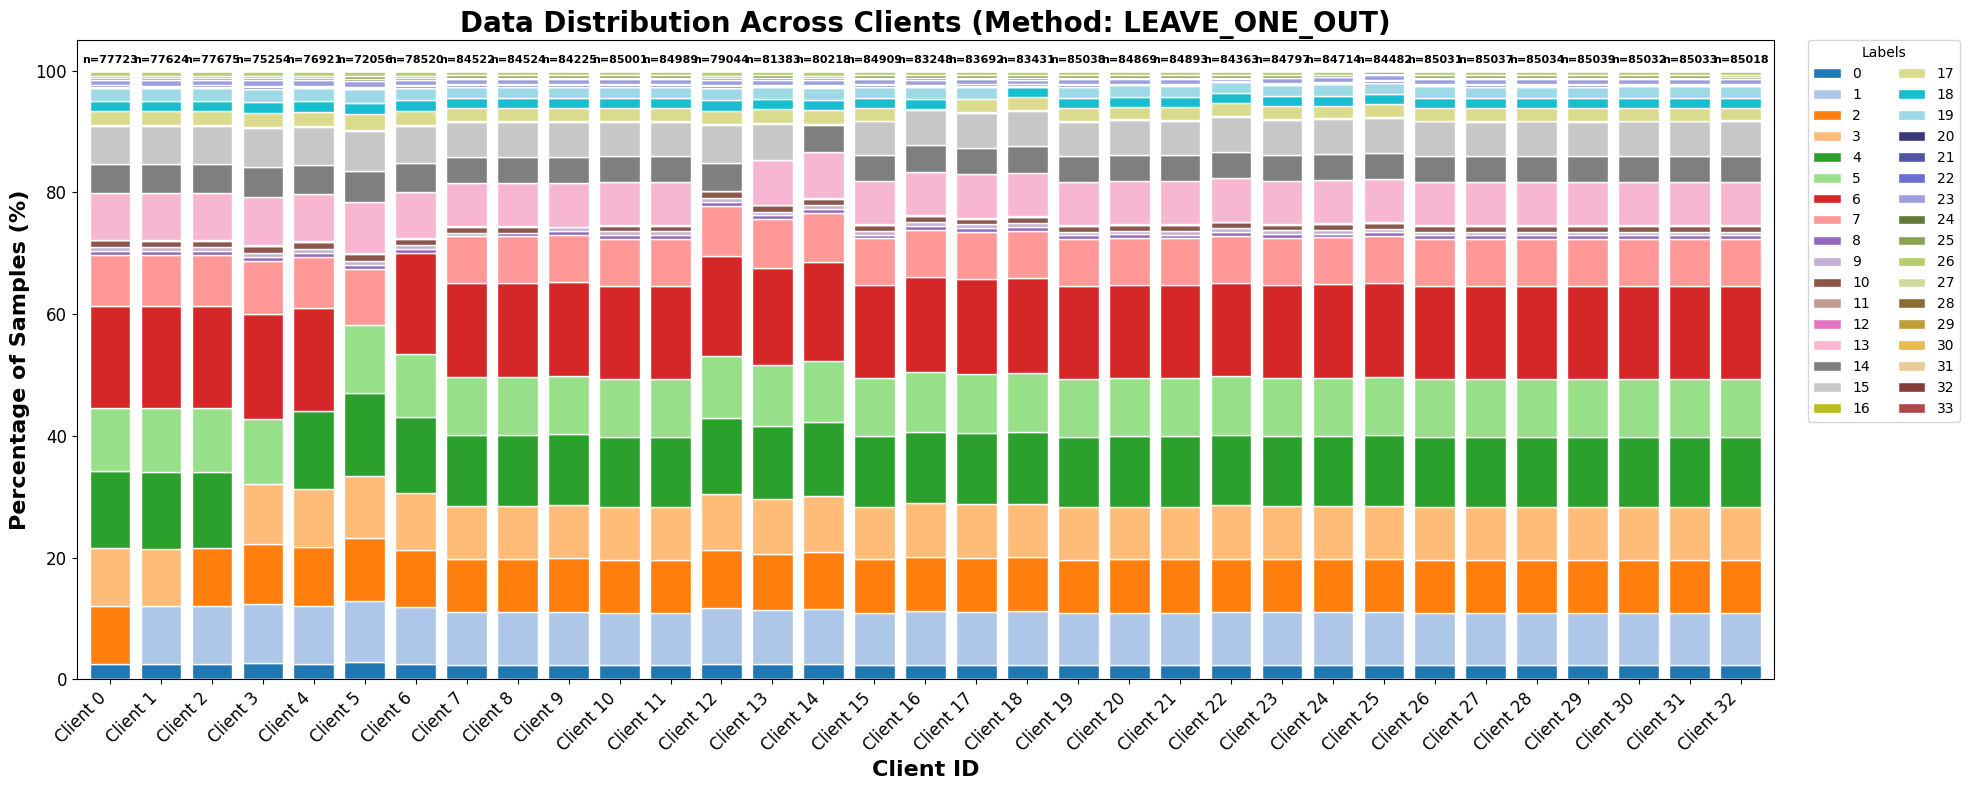

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
client_distributions = {}
for i in range(NUM_OF_CLIENTS):
    # .value_counts() returns a Series, convert it to a dictionary
    client_distributions[f'Client {i}'] = fl_y_train[i].value_counts().to_dict()

# 2. Convert the dictionary to a Pandas DataFrame for easy manipulation
df_dist = pd.DataFrame(client_distributions).fillna(0).astype(int)
df_dist = df_dist.sort_index() # Sort the labels numerically for consistent colors

# 3. Plot a Stacked Bar Chart
# Convert absolute counts to percentages for the chart y-axis
df_percent = df_dist.divide(df_dist.sum(axis=0), axis=1) * 100

# Create a diverse color palette to ensure distinct colors for all 34 labels
# We combine multiple colormaps to get enough unique colors
colors1 = plt.cm.get_cmap('tab20', 20)
colors2 = plt.cm.get_cmap('tab20b', 20)
colors = np.vstack((colors1.colors, colors2.colors))

# Plot the chart with a much wider figure size
ax = df_percent.T.plot(
    kind='bar',
    stacked=True,
    figsize=(22, 8), # Increased width for readability
    color=colors,
    width=0.8,
    edgecolor="white"
)

# 4. Customize the plot for better presentation
plt.title(f'Data Distribution Across Clients (Method: {METHOD})', fontsize=20, fontweight='bold')
plt.xlabel('Client ID', fontsize=16, fontweight='bold')
plt.ylabel('Percentage of Samples (%)', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12) # Rotate labels for better fit
plt.yticks(fontsize=12)
plt.ylim(0, 105) # Add a little space at the top for annotations

# Move the legend outside the plot and arrange it in 2 columns
plt.legend(
    title='Labels',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0.,
    fontsize='medium',
    ncol=2 # Arrange legend in two columns
)

# Adjust layout to prevent the legend from being cut off
plt.tight_layout(rect=[0, 0, 0.9, 1])

# Add total sample count (n=...) above each bar for context
for i, total in enumerate(df_dist.sum(axis=0)):
    ax.text(i, 101, f'n={total}', ha='center', va='bottom', fontsize=8, fontweight='bold')

#  plt.show()

Prepare an output directory where we can store the results of the federated learning

In [ ]:
# Create an "Output" directory if it doesnt exist already
if not os.path.exists("Output"):
    os.makedirs("Output")

sub_dir_name = f"train_size-{train_size}"

# if sub_dir_name does not exist, create it
if not os.path.exists(f"Output/{sub_dir_name}"):
    os.makedirs(f"Output/{sub_dir_name}")

test_directory_name = f"{METHOD}_Classifier-{class_size}_Clients-{NUM_OF_CLIENTS}"
output_path = f"Output/{sub_dir_name}/{test_directory_name}" # Lưu lại đường dẫn để dùng sau

# Create an "Output/{METHOD}-{NUM_OF_CLIENTS}-{NUM_OF_ROUNDS}" directory if it doesnt exist already
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Ensure the directory is empty
for file in os.listdir(output_path):
    file_path = os.path.join(output_path, file)
    if os.path.isfile(file_path):
        os.unlink(file_path)

# Original training size is the sum of all the fl_X_train sizes
original_training_size = 0
for i in range(len(fl_X_train)):
    original_training_size += fl_X_train[i].shape[0]

# Write this same info to the output directory/Class Split Info.txt
with open(f"{output_path}/Class Split Info.txt", "w") as f:
    for i in range(len(fl_X_train)):
        f.write(f"Client ID: {i}\n")
        f.write(f"fl_X_train.shape: {fl_X_train[i].shape}\n")
        f.write(f"Training data used {original_training_size}\n")
        f.write(f"fl_y_train.value_counts():\n{fl_y_train[i].value_counts().to_string()}\n")
        f.write(f"fl_y_train.unique(): {fl_y_train[i].unique()}\n\n")

print(f"Output directory and summary file created at: {output_path}")

Output directory and summary file created at: Output/train_size-2806456/LEAVE_ONE_OUT_Classifier-34_Clients-33


Convert the training dataset


In [ ]:
# Convert the testing dataframe to numpy arrays for TensorFlow/Keras
X_test = test_df[X_columns].to_numpy()
y_test = test_df[y_column].to_numpy()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Determine the number of unique classes in the target column
num_unique_classes = len(train_df[y_column].unique())

# Store the shapes of the original dataframes for logging purposes before deleting them
train_df_shape = train_df.shape
test_df_shape = test_df.shape

# Now that we have fl_X_train, fl_y_train, X_test, and y_test extracted,
# we can safely delete the large dataframes to free up memory
if 'train_df' in locals():
    del train_df
if 'test_df' in locals():
    del test_df
if 'client_df' in locals():
    del client_df
print("Final data conversion to numpy complete. Dataframes deleted to free up memory.")

Final data conversion to numpy complete. Dataframes deleted to free up memory.


Data check

In [ ]:
print("NUM_CLIENTS:", NUM_OF_CLIENTS)

print("NUM_ROUNDS:", NUM_OF_ROUNDS)
print()


print("Original training size: {}".format(original_training_size))


print("Checking training data split groups")
for i in range(len(fl_X_train)):
    print(i, ":", "X Shape", fl_X_train[i].shape, "Y Shape", fl_y_train[i].shape)


# Print the sizes of X_test and y_test
print("\nChecking testing data")
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

print("\nDeploy Simulation")

NUM_CLIENTS: 33
NUM_ROUNDS: 5

Original training size: 2723339
Checking training data split groups
0 : X Shape (77723, 39) Y Shape (77723,)
1 : X Shape (77624, 39) Y Shape (77624,)
2 : X Shape (77675, 39) Y Shape (77675,)
3 : X Shape (75254, 39) Y Shape (75254,)
4 : X Shape (76921, 39) Y Shape (76921,)
5 : X Shape (72056, 39) Y Shape (72056,)
6 : X Shape (78520, 39) Y Shape (78520,)
7 : X Shape (84522, 39) Y Shape (84522,)
8 : X Shape (84524, 39) Y Shape (84524,)
9 : X Shape (84225, 39) Y Shape (84225,)
10 : X Shape (85001, 39) Y Shape (85001,)
11 : X Shape (84989, 39) Y Shape (84989,)
12 : X Shape (79044, 39) Y Shape (79044,)
13 : X Shape (81383, 39) Y Shape (81383,)
14 : X Shape (80218, 39) Y Shape (80218,)
15 : X Shape (84909, 39) Y Shape (84909,)
16 : X Shape (83248, 39) Y Shape (83248,)
17 : X Shape (83692, 39) Y Shape (83692,)
18 : X Shape (83431, 39) Y Shape (83431,)
19 : X Shape (85038, 39) Y Shape (85038,)
20 : X Shape (84869, 39) Y Shape (84869,)
21 : X Shape (84893, 39) Y Sh

In [ ]:
print("X_test min/max/mean:", np.min(X_test), np.max(X_test), np.mean(X_test))
print("Client 0 X min/max/mean:", np.min(fl_X_train[0]), np.max(fl_X_train[0]), np.mean(fl_X_train[0]))

X_test min/max/mean: -52.92539879493338 476.80242930958366 -0.000634890663062242
Client 0 X min/max/mean: -52.92539879493338 136.22155747982657 -0.02330975502083858


#Federated Learning

Import the libraries and print the versions


In [ ]:
import os
import flwr as fl
import numpy as np
import tensorflow as tf

# Make TensorFlow log less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout


Define the Client and Server code

In [ ]:
import os
import flwr as fl
import numpy as np
import tensorflow as tf

print('scikit-learn {}.'.format(sklearn.__version__))
print("flwr", fl.__version__)
print("numpy", np.__version__)
print("tf", tf.__version__)
# Make TensorFlow log less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout

import datetime

client_evaluations = []

class NumpyFlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, model, train_data, train_labels):
        self.model = model
        self.cid = cid
        self.train_data = train_data
        self.train_labels = train_labels

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        print ("Client ", self.cid, "Training...")
        self.model.fit(self.train_data, self.train_labels, epochs=5, batch_size=32)
        print ("Client ", self.cid, "Training complete...")
        return self.model.get_weights(), len(self.train_data), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        print ("Client ", self.cid, "Evaluating...")
        loss, accuracy = self.model.evaluate(self.train_data, self.train_labels, batch_size=32)
        print(f"{Colours.YELLOW.value}Client {self.cid} evaluation complete - Accuracy: {accuracy:.6f}, Loss: {loss:.6f}{Colours.NORMAL.value}")

        # Write the same message to the "Output/{cid}_Evaluation.txt" file
        with open(f"Output/{sub_dir_name}/{test_directory_name}/{self.cid}_Evaluation.txt", "a") as f:
            f.write(f"{datetime.datetime.now()} - Client {self.cid} evaluation complete - Accuracy: {accuracy:.6f}, Loss: {loss:.6f}\n")

            # Close the file
            f.close()

        return loss, len(self.train_data), {"accuracy": accuracy}

    def predict(self, incoming):
        prediction = np.argmax( self.model.predict(incoming) ,axis=1)
        return prediction

def client_fn(cid: str) -> NumpyFlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    #model = tf.keras.applications.MobileNetV2((32, 32, 3), classes=10, weights=None)
    #model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])

    print ("Client ID:", cid)

    model = Sequential([
      #Flatten(input_shape=(79,1)),
      Dense(50, activation='relu', input_shape=(fl_X_train[0].shape[1],)),
      Dense(25, activation='relu'),
      Dense(num_unique_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


    partition_id = int(cid)
    X_train_c = fl_X_train[partition_id]
    y_train_c = fl_y_train[partition_id]

    # Create a  single Flower client representing a single organization
    return NumpyFlowerClient(cid, model, X_train_c, y_train_c)


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
eval_count = 0

def get_evaluate_fn(server_model):
    global eval_count

    def evaluate(server_round, parameters, config):
        global eval_count

        # Update model weights from the latest client parameters
        server_model.set_weights(parameters)
        print(f"Server Evaluating... Evaluation Count: {eval_count}")

        # Evaluate the model on the test set
        loss, accuracy = server_model.evaluate(X_test, y_test)

        # Record accuracy and loss for visualization or tracking
        server_accuracy_history.append(accuracy)
        server_loss_history.append(loss)

        # Make predictions and save them to a file
        y_pred = server_model.predict(X_test)
        print("Prediction: ", y_pred, y_pred.shape)
        np.save("y_pred-" + str(eval_count) + ".npy", y_pred)

        # Print evaluation result to console
        print(f"{Colours.YELLOW.value}Server evaluation complete - Accuracy: {accuracy:.4f}, Loss: {loss:.4f}{Colours.NORMAL.value}")

        # Write evaluation log to file
        with open(f"Output/{sub_dir_name}/{test_directory_name}/Server_Evaluation.txt", "a") as f:
            f.write(f"{datetime.datetime.now()} - {server_round} : Server evaluation complete - Accuracy: {accuracy:.4f}, Loss: {loss:.4f}\n")

        # Increment evaluation counter
        eval_count += 1

        return loss, {"accuracy": accuracy}

    return evaluate



scikit-learn 1.6.1.
flwr 1.20.0
numpy 2.0.2
tf 2.19.0


Initialize Server Model and Strategy

In [ ]:
from flwr.common import ndarrays_to_parameters
server_model = Sequential([
    #Flatten(input_shape=(79,1)),
    Flatten(input_shape=(fl_X_train[0].shape[1] , 1)),
    Dense(50, activation='relu'),
    Dense(25, activation='relu'),
    Dense(num_unique_classes, activation='softmax')
])


server_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

initial_weights = server_model.get_weights()
initial_parameters = ndarrays_to_parameters(initial_weights)

# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
        fraction_fit=1.0,
        fraction_evaluate=0.5,
        min_fit_clients=10, #10,
        min_evaluate_clients=5, #5,
        min_available_clients=10, #10,
        evaluate_fn=get_evaluate_fn(server_model),
        #evaluate_metrics_aggregation_fn=weighted_average,
)
# Test FedAdam
# strategy = fl.server.strategy.FedAdam(
#         fraction_fit=1.0,
#         fraction_evaluate=0.5,
#         min_fit_clients=10,
#         min_evaluate_clients=5,
#         min_available_clients=10,
#         evaluate_fn=get_evaluate_fn(server_model),
#         eta=1.0,           # Server-side learning rate
#         beta_1=0.9,
#         beta_2=0.999,
#         tau=1e-9,
#         initial_parameters=initial_parameters
# )

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Deploy Simulation


Deploy simulation... Method = LEAVE_ONE_OUT - Individual (34) Classifier
Number of Clients = 33

Writing output to: train_size-2806456/LEAVE_ONE_OUT_Classifier-34_Clients-33



	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=5, no round_timeout
2025-08-20 07:09:35,754	INFO worker.py:1771 -- Started a local Ray instance.
/usr/local/lib/python3.12/dist-packages/jupyter_client

(ClientAppActor pid=1715) Client ID: 5
Server Evaluating... Evaluation Count: 0
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step - accuracy: 0.0199 - loss: 3.5720
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 32s 1ms/step
Prediction:  [[0.03361375 0.03480801 0.02630133 ... 0.02588343 0.02550754 0.02976171]
 [0.02422309 0.03234754 0.05421331 ... 0.02352194 0.01819041 0.01463096]
 [0.02369872 0.03795942 0.02384055 ... 0.024004   0.02578877 0.02094381]
 ...
 [0.01489241 0.06645945 0.02957171 ... 0.00542535 0.02070759 0.03304766]
 [0.02643991 0.03157369 0.03413931 ... 0.03026343 0.02391561 0.02359286]
 [0.02582383 0.03114824 0.03485632 ... 0.02909939 0.02367673 0.02291951]] (744790, 34)


INFO :      initial parameters (loss, other metrics): 3.5717809200286865, {'accuracy': 0.0199546180665493}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 33 clients (out of 33)


Server evaluation complete - Accuracy: 0.0200, Loss: 3.5718


(ClientAppActor pid=1715) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1715) 
(ClientAppActor pid=1715)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1715)             entirely in future versions of Flower.
(ClientAppActor pid=1715)         
(ClientAppActor pid=1715) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1715)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(ClientAppActor pid=1715) Client ID: 28


(ClientAppActor pid=1715) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1715) Client  28 Training...
(ClientAppActor pid=1715) Epoch 1/5


(ClientAppActor pid=1713) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1713) 
(ClientAppActor pid=1713)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1713)             entirely in future versions of Flower.
(ClientAppActor pid=1713)         
(ClientAppActor pid=1713) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1713)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(ClientAppActor pid=1713) Client ID: 13
  17/2658 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.0939 - loss: 3.4326    
  53/2658 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.1764 - loss: 3.2414
  83/2658 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.2450 - loss: 3.0637
 113/2658 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.3013 - loss: 2.8839
 245/2544 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.4523 - loss: 2.2440
 294/2544 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.4832 - loss: 2.0907
 305/2544 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.4892 - loss: 2.0601
(ClientAppActor pid=1713) Client  13 Training...
(ClientAppActor pid=1713) Epoch 1/5
  16/2544 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.0703 - loss: 3.4553        
1535/2544 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6708 - loss: 1.0405 [repeated 88x across cluster]
1384/2658 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6348 - loss: 1.1623 [repeated 4x across cluster]
(ClientAppActor pid=1713) Epoch 2/

(ClientAppActor pid=1713) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1713) 
(ClientAppActor pid=1713)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1713)             entirely in future versions of Flower.
(ClientAppActor pid=1713)         
(ClientAppActor pid=1713) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1713)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1713) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1713) Client ID: 25
2132/2658 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7452 - loss: 0.4892
(ClientAppActor pid=1713) Client  25 Training...
(ClientAppActor pid=1713) Epoch 1/5
2213/2658 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7453 - loss: 0.4891
2284/2658 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7454 - loss: 0.4890
2269/2658 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7454 - loss: 0.4890 [repeated 84x across cluster]
2346/2658 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7455 - loss: 0.4889
2651/2658 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7457 - loss: 0.4886
2658/2658 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.7457 - loss: 0.4886


(ClientAppActor pid=1715) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1715) 
(ClientAppActor pid=1715)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1715)             entirely in future versions of Flower.
(ClientAppActor pid=1715)         
(ClientAppActor pid=1715) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1715)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  17/2641 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.0662 - loss: 3.4423    
(ClientAppActor pid=1715) Client  28 Training complete...
(ClientAppActor pid=1715) Client ID: 6
(ClientAppActor pid=1715) Client  6 Training...
(ClientAppActor pid=1715) Epoch 1/5
 982/2641 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6115 - loss: 1.2976
1019/2641 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6146 - loss: 1.2790 [repeated 56x across cluster]
1038/2641 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6161 - loss: 1.2698
1262/2641 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6315 - loss: 1.1775
  15/2454 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.0676 - loss: 3.4676    
1522/2641 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6448 - loss: 1.0977
1546/2641 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6458 - loss: 1.0914
1553/2641 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6461 - loss: 1.0896
1576/2641 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6470 - loss: 1.0837
1584/2641 ━

(ClientAppActor pid=1715) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1715) 
(ClientAppActor pid=1715)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1715)             entirely in future versions of Flower.
(ClientAppActor pid=1715)         
(ClientAppActor pid=1715) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1715)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1715) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1715) Client  17 Training...
(ClientAppActor pid=1715) Epoch 1/5


(ClientAppActor pid=1713) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1713) 
(ClientAppActor pid=1713)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1713)             entirely in future versions of Flower.
(ClientAppActor pid=1713)         
(ClientAppActor pid=1713) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1713)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  11/2616 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.0428 - loss: 3.5898       
  29/2616 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.1003 - loss: 3.4509
  49/2616 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.1585 - loss: 3.3184
  67/2616 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.2075 - loss: 3.2067
  85/2616 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.2483 - loss: 3.0983
 104/2616 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.2858 - loss: 2.9847
 114/2616 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.3034 - loss: 2.9258
 135/2616 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.3362 - loss: 2.8059
 158/2616 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.3663 - loss: 2.6834
 177/2616 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.3872 - loss: 2.5913
 197/2616 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.4063 - loss: 2.5028
 216/2616 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.4223 - loss: 2.4252
 234/2616 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0

(ClientAppActor pid=1715) 
(ClientAppActor pid=1715)         
(ClientAppActor pid=1713) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1715) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1715)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1715)             entirely in future versions of Flower.
(ClientAppActor pid=1715) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first lay

(ClientAppActor pid=1715) Client ID: 22
(ClientAppActor pid=1715) Client  22 Training...
(ClientAppActor pid=1715) Epoch 1/5
   1/2637 ━━━━━━━━━━━━━━━━━━━━ 1:15:59 2s/step - accuracy: 0.0312 - loss: 3.4791
  33/2637 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.1383 - loss: 3.3455
2616/2616 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7582 - loss: 0.4700 [repeated 2x across cluster]


(ClientAppActor pid=1713) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1713) 
(ClientAppActor pid=1713)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1713)             entirely in future versions of Flower.
(ClientAppActor pid=1713)         
(ClientAppActor pid=1713) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1713)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 795/2637 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5936 - loss: 1.4340 [repeated 62x across cluster]
(ClientAppActor pid=1713) Client  23 Training complete...
(ClientAppActor pid=1713) Client ID: 12
(ClientAppActor pid=1713) Client  12 Training...
(ClientAppActor pid=1713) Epoch 1/5
   1/2471 ━━━━━━━━━━━━━━━━━━━━ 1:08:39 2s/step - accuracy: 0.0312 - loss: 3.3969
  30/2471 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.1371 - loss: 3.3535
 263/2471 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.4864 - loss: 2.1697 [repeated 7x across cluster]
1185/2471 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6622 - loss: 1.1580 [repeated 83x across cluster]
(ClientAppActor pid=1715) Epoch 2/5
   1/2637 ━━━━━━━━━━━━━━━━━━━━ 4:43 108ms/step - accuracy: 0.6562 - loss: 0.6517
2637/2637 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6781 - loss: 0.9159 [repeated 9x across cluster]
  16/2637 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.7033 - loss: 0.5505
  34/2637 ━━━━━━━━━━━━━━━━━━━━ 16s 6m

(ClientAppActor pid=1715) 
(ClientAppActor pid=1715)         
(ClientAppActor pid=1713) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1715) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1715)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1715)             entirely in future versions of Flower.
(ClientAppActor pid=1715) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first lay

(ClientAppActor pid=1715) Client ID: 16
(ClientAppActor pid=1715) Client  16 Training...
(ClientAppActor pid=1715) Epoch 1/5
2637/2637 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7526 - loss: 0.4753 [repeated 5x across cluster]


(ClientAppActor pid=1713) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1713) 
(ClientAppActor pid=1713)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1713)             entirely in future versions of Flower.
(ClientAppActor pid=1713)         
(ClientAppActor pid=1713) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1713)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


   1/2602 ━━━━━━━━━━━━━━━━━━━━ 2:42:20 4s/step - accuracy: 0.0625 - loss: 3.5149
2466/2471 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7823 - loss: 0.4197 [repeated 40x across cluster]
  19/2602 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.0815 - loss: 3.4624
  39/2602 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.1369 - loss: 3.3617
  56/2602 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.1828 - loss: 3.2656
  72/2602 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.2238 - loss: 3.1722
  87/2602 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.2581 - loss: 3.0837
 103/2602 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.2899 - loss: 2.9879
 118/2602 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.3157 - loss: 2.8996
 140/2602 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.3480 - loss: 2.7768
(ClientAppActor pid=1713) Client  12 Training complete...
 157/2602 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.3691 - loss: 2.6890
 170/2602 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accura

(ClientAppActor pid=1715) 
(ClientAppActor pid=1715)         
(ClientAppActor pid=1715) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=1715) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1715)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1715)             entirely in future versions of Flower.
(ClientAppActor pid=1715) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(sh

(ClientAppActor pid=1715) Client ID: 7
(ClientAppActor pid=1715) Client  7 Training...
(ClientAppActor pid=1715) Epoch 1/5
   1/2642 ━━━━━━━━━━━━━━━━━━━━ 1:19:31 2s/step - accuracy: 0.0000e+00 - loss: 3.6655
  29/2642 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.0993 - loss: 3.4227
  45/2642 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.1468 - loss: 3.3263
  58/2642 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.1870 - loss: 3.2466


(ClientAppActor pid=1713) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1713) 
(ClientAppActor pid=1713)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1713)             entirely in future versions of Flower.
(ClientAppActor pid=1713)         
(ClientAppActor pid=1713) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1713)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  89/2642 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.2617 - loss: 3.0503
 120/2642 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.3165 - loss: 2.8646
 152/2642 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.3593 - loss: 2.6917
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7608 - loss: 0.4689
 180/2642 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.3892 - loss: 2.5564
 216/2642 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.4207 - loss: 2.4041
 229/2642 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.4303 - loss: 2.3547
 244/2642 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.4406 - loss: 2.3009
 263/2642 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.4526 - loss: 2.2377
 283/2642 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.4640 - loss: 2.1764
 299/2642 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.4724 - loss: 2.1309
 319/2642 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.4822 - loss: 2.0779
 338/2642 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.4907 -

(ClientAppActor pid=1713) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1713) 
(ClientAppActor pid=1713)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1713)             entirely in future versions of Flower.
(ClientAppActor pid=1713)         
(ClientAppActor pid=1713) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1713) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first lay

(ClientAppActor pid=1713) Client ID: 30
(ClientAppActor pid=1713) Client  30 Training...
(ClientAppActor pid=1713) Epoch 1/5


(ClientAppActor pid=1715) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1715) 
(ClientAppActor pid=1715)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1715)             entirely in future versions of Flower.
(ClientAppActor pid=1715)         


  18/2658 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.0820 - loss: 3.4419    
2610/2642 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7470 - loss: 0.4886 [repeated 49x across cluster]
2642/2642 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.7470 - loss: 0.4886 [repeated 3x across cluster]
(ClientAppActor pid=1715) Client  7 Training complete...
(ClientAppActor pid=1715) Client ID: 9
(ClientAppActor pid=1715) Client  9 Training...
(ClientAppActor pid=1715) Epoch 1/5
  15/2633 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.0641 - loss: 3.5105        
1553/2658 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6461 - loss: 1.1062 [repeated 87x across cluster]
1575/2633 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6458 - loss: 1.1056 [repeated 7x across cluster]
2383/2658 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6701 - loss: 0.9542 [repeated 92x across cluster]
2015/2658 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6614 - loss: 1.0091 [repeated 2x across cluster]
(ClientAppActo

(ClientAppActor pid=1715) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1715) 
(ClientAppActor pid=1715)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1715)             entirely in future versions of Flower.
(ClientAppActor pid=1715)         
(ClientAppActor pid=1715) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 2x across cluster]
(ClientAppActor pid=1715)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 2x across cluster]
(ClientAppActor pid=1715) WARNING :   Deprecation Warning:

(ClientAppActor pid=1715) Client ID: 8
(ClientAppActor pid=1715) Client  8 Training...
(ClientAppActor pid=1715) Epoch 1/5


(ClientAppActor pid=1713) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1713) 
(ClientAppActor pid=1713)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1713)             entirely in future versions of Flower.
(ClientAppActor pid=1713)         


2658/2658 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.7482 - loss: 0.4902 [repeated 9x across cluster]
  17/2642 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.0719 - loss: 3.4857    
   1/2404 ━━━━━━━━━━━━━━━━━━━━ 1:31:50 2s/step - accuracy: 0.0000e+00 - loss: 3.5777
  31/2404 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.1230 - loss: 3.3736
 330/2404 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.4954 - loss: 1.9931 [repeated 31x across cluster]
(ClientAppActor pid=1713) Client  30 Training complete...
(ClientAppActor pid=1713) Client ID: 4
(ClientAppActor pid=1713) Client  4 Training...
(ClientAppActor pid=1713) Epoch 1/5
 557/2404 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5692 - loss: 1.6036
1884/2404 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6805 - loss: 0.9836 [repeated 97x across cluster]
(ClientAppActor pid=1713) Epoch 2/5
  19/2404 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8060 - loss: 0.4242   
  35/2404 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8016 

(ClientAppActor pid=1713) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1713) 
(ClientAppActor pid=1713)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1713)             entirely in future versions of Flower.
(ClientAppActor pid=1713)         
(ClientAppActor pid=1713) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 2x across cluster]
(ClientAppActor pid=1713)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 2x across cluster]
(ClientAppActor pid=1713) WARNING :   Deprecation Warning:

(ClientAppActor pid=1713) Client ID: 27
(ClientAppActor pid=1713) Client  27 Training...
(ClientAppActor pid=1713) Epoch 1/5
  17/2658 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.0633 - loss: 3.4970    
2410/2642 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7474 - loss: 0.4941 [repeated 66x across cluster]
2642/2642 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.7474 - loss: 0.4937
1808/2642 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7476 - loss: 0.4950 [repeated 3x across cluster]
 233/2658 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.4184 - loss: 2.3725
 264/2658 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.4393 - loss: 2.2675 


(ClientAppActor pid=1715) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1715) 
(ClientAppActor pid=1715)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1715)             entirely in future versions of Flower.
(ClientAppActor pid=1715)         


(ClientAppActor pid=1715) Client  8 Training complete...
(ClientAppActor pid=1715) Client ID: 0
  62/2429 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.1705 - loss: 3.2572
(ClientAppActor pid=1715) Client  0 Training...
(ClientAppActor pid=1715) Epoch 1/5
 556/2429 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5264 - loss: 1.7305
  18/2429 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.0589 - loss: 3.5212        
1400/2658 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6333 - loss: 1.1656 [repeated 70x across cluster]
1428/2658 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6348 - loss: 1.1569 [repeated 3x across cluster]
1987/2658 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6566 - loss: 1.0257
2087/2658 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6595 - loss: 1.0083 [repeated 86x across cluster]
2008/2658 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6573 - loss: 1.0220 [repeated 9x across cluster]
(ClientAppActor pid=1713) Epoch 2/5
  16/2658 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step

(ClientAppActor pid=1715) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1715) 
(ClientAppActor pid=1715)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1715)             entirely in future versions of Flower.
(ClientAppActor pid=1715)         
(ClientAppActor pid=1715) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 2x across cluster]
(ClientAppActor pid=1715)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 2x across cluster]
(ClientAppActor pid=1715) WARNING :   Deprecation Warning:

(ClientAppActor pid=1715) Client ID: 20
(ClientAppActor pid=1715) Client  20 Training...
(ClientAppActor pid=1715) Epoch 1/5


(ClientAppActor pid=1713) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1713) 
(ClientAppActor pid=1713)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1713)             entirely in future versions of Flower.
(ClientAppActor pid=1713)         


   1/2653 ━━━━━━━━━━━━━━━━━━━━ 2:19:48 3s/step - accuracy: 0.0000e+00 - loss: 3.6103
2653/2658 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7443 - loss: 0.4905 [repeated 62x across cluster]
2658/2658 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7443 - loss: 0.4905 [repeated 9x across cluster]
  28/2653 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.0837 - loss: 3.4280 
  18/2648 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.0641 - loss: 3.4832        
 235/2648 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.4395 - loss: 2.3155
(ClientAppActor pid=1713) Client  27 Training complete...
 364/2648 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5077 - loss: 1.9576
(ClientAppActor pid=1713) Client ID: 24
(ClientAppActor pid=1713) Client  24 Training...
(ClientAppActor pid=1713) Epoch 1/5
 511/2648 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5527 - loss: 1.7047
1390/2648 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6450 - loss: 1.1408 [repeated 81x across cluster]
1260/2648 ━━━━━━━

(ClientAppActor pid=1713) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1713) 
(ClientAppActor pid=1713)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1713)             entirely in future versions of Flower.
(ClientAppActor pid=1713)         
(ClientAppActor pid=1713) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 2x across cluster]
(ClientAppActor pid=1713)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 2x across cluster]
(ClientAppActor pid=1713) WARNING :   Deprecation Warning:

(ClientAppActor pid=1713) Client ID: 31
(ClientAppActor pid=1713) Client  31 Training...
(ClientAppActor pid=1713) Epoch 1/5
2572/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7508 - loss: 0.4790 [repeated 82x across cluster]


(ClientAppActor pid=1715) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1715) 
(ClientAppActor pid=1715)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1715)             entirely in future versions of Flower.
(ClientAppActor pid=1715)         


   1/2658 ━━━━━━━━━━━━━━━━━━━━ 2:21:52 3s/step - accuracy: 0.0000e+00 - loss: 3.5102
  20/2658 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.0685 - loss: 3.4653
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7508 - loss: 0.4790 [repeated 2x across cluster]
  38/2658 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.1128 - loss: 3.3667
  53/2658 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.1570 - loss: 3.2800
  71/2658 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.2052 - loss: 3.1727
  87/2658 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.2428 - loss: 3.0758
 104/2658 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.2778 - loss: 2.9741
 118/2658 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.3027 - loss: 2.8926
 139/2658 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.3349 - loss: 2.7760
 154/2658 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.3546 - loss: 2.6985
 182/2658 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.3857 - loss: 2.5664
 203/2658 ━━━━━━━━━━━━━━━━━━

(ClientAppActor pid=1713) 
(ClientAppActor pid=1713)         
(ClientAppActor pid=1713) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 2x across cluster]
(ClientAppActor pid=1713)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 2x across cluster]
(ClientAppActor pid=1715) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1713) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common

(ClientAppActor pid=1713) Client ID: 18
(ClientAppActor pid=1713) Client  18 Training...
(ClientAppActor pid=1713) Epoch 1/5
1975/2653 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7483 - loss: 0.4846
  16/2608 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.0735 - loss: 3.4535        
  74/2608 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.2178 - loss: 3.1358
  96/2608 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.2674 - loss: 3.0006


(ClientAppActor pid=1715) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1715) 
(ClientAppActor pid=1715)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1715)             entirely in future versions of Flower.
(ClientAppActor pid=1715)         


 118/2608 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.3075 - loss: 2.8703
 145/2608 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.3468 - loss: 2.7215
 176/2608 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.3819 - loss: 2.5687
 210/2608 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.4135 - loss: 2.4214
 246/2608 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.4405 - loss: 2.2885
 658/2608 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5742 - loss: 1.5463 [repeated 48x across cluster]
(ClientAppActor pid=1715) Client  21 Training complete...
(ClientAppActor pid=1715) Client ID: 15
(ClientAppActor pid=1715) Client  15 Training...
(ClientAppActor pid=1715) Epoch 1/5
 610/2654 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5693 - loss: 1.6078
 627/2654 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5723 - loss: 1.5897
 676/2654 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5802 - loss: 1.5411
  17/2654 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.0722 - loss: 3.4569    
 124/2654

(ClientAppActor pid=1713) 
(ClientAppActor pid=1713)         
(ClientAppActor pid=1713) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 2x across cluster]
(ClientAppActor pid=1713)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 2x across cluster]
(ClientAppActor pid=1715) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1713) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common

(ClientAppActor pid=1713) Client ID: 26


(ClientAppActor pid=1713) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1713) Client  26 Training...
(ClientAppActor pid=1713) Epoch 1/5
2121/2654 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7491 - loss: 0.4821
2201/2654 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7491 - loss: 0.4821 [repeated 5x across cluster]
2580/2654 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7490 - loss: 0.4827 [repeated 53x across cluster]


(ClientAppActor pid=1715) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1715) 
(ClientAppActor pid=1715)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1715)             entirely in future versions of Flower.
(ClientAppActor pid=1715)         


  16/2658 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.0749 - loss: 3.4380    
(ClientAppActor pid=1715) Client  15 Training complete...
(ClientAppActor pid=1715) Client ID: 29
(ClientAppActor pid=1715) Client  29 Training...
(ClientAppActor pid=1715) Epoch 1/5
 123/2658 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.3103 - loss: 2.8704
 177/2658 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.3774 - loss: 2.5956
 268/2658 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.4486 - loss: 2.2481
 221/2658 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.4163 - loss: 2.4110 [repeated 3x across cluster]
 689/2658 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5744 - loss: 1.5388
1247/2658 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6252 - loss: 1.2117 [repeated 59x across cluster]
  17/2658 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.0747 - loss: 3.4714        
1300/2658 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6283 - loss: 1.1927
2158/2658 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy

(ClientAppActor pid=1713) 
(ClientAppActor pid=1713)         
(ClientAppActor pid=1713) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 2x across cluster]
(ClientAppActor pid=1713)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 2x across cluster]
(ClientAppActor pid=1715) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1713) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common

(ClientAppActor pid=1713) Client ID: 11
(ClientAppActor pid=1713) Client  11 Training...
(ClientAppActor pid=1713) Epoch 1/5
2658/2658 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7489 - loss: 0.4856
2426/2658 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7460 - loss: 0.4870 [repeated 87x across cluster]


(ClientAppActor pid=1715) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1715) 
(ClientAppActor pid=1715)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1715)             entirely in future versions of Flower.
(ClientAppActor pid=1715)         


   1/2656 ━━━━━━━━━━━━━━━━━━━━ 1:28:14 2s/step - accuracy: 0.0625 - loss: 3.4703
  32/2656 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.1208 - loss: 3.3570
  91/2656 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.2634 - loss: 3.0175
 104/2656 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.2872 - loss: 2.9425
 121/2656 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.3148 - loss: 2.8464
 137/2656 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.3377 - loss: 2.7595
 157/2656 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.3624 - loss: 2.6567
 176/2656 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.3828 - loss: 2.5656
 186/2656 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.3925 - loss: 2.5206
 204/2656 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.4084 - loss: 2.4443
 223/2656 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.4235 - loss: 2.3697
 237/2656 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.4336 - loss: 2.3187
 256/2656 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.4462

(ClientAppActor pid=1715) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1715) 
(ClientAppActor pid=1715)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1715)             entirely in future versions of Flower.
(ClientAppActor pid=1715)         
(ClientAppActor pid=1715) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 2x across cluster]
(ClientAppActor pid=1715)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 2x across cluster]
(ClientAppActor pid=1715) WARNING :   Deprecation Warning:

(ClientAppActor pid=1715) Client ID: 19
(ClientAppActor pid=1715) Client  19 Training...
2291/2656 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7481 - loss: 0.4856 [repeated 87x across cluster]
(ClientAppActor pid=1715) Epoch 1/5


(ClientAppActor pid=1713) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1713) 
(ClientAppActor pid=1713)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1713)             entirely in future versions of Flower.
(ClientAppActor pid=1713)         


   1/2658 ━━━━━━━━━━━━━━━━━━━━ 1:22:21 2s/step - accuracy: 0.0000e+00 - loss: 3.6131
  35/2658 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.1235 - loss: 3.3567
(ClientAppActor pid=1713) Client  11 Training complete...
2656/2656 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.7481 - loss: 0.4857
(ClientAppActor pid=1713) Client ID: 32
(ClientAppActor pid=1713) Client  32 Training...
 463/2657 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5219 - loss: 1.8337 [repeated 55x across cluster]
(ClientAppActor pid=1713) Epoch 1/5
1035/2658 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6107 - loss: 1.2976
1050/2658 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6118 - loss: 1.2904
   1/2657 ━━━━━━━━━━━━━━━━━━━━ 1:21:09 2s/step - accuracy: 0.0000e+00 - loss: 3.7688
  34/2657 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.0867 - loss: 3.4279
1694/2657 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6464 - loss: 1.0960 [repeated 94x across cluster]
2369/2658 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - ac

(ClientAppActor pid=1715) 
(ClientAppActor pid=1715)         
(ClientAppActor pid=1715) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 2x across cluster]
(ClientAppActor pid=1715)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 2x across cluster]
(ClientAppActor pid=1715) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=1715) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context`

(ClientAppActor pid=1715) Client ID: 14
(ClientAppActor pid=1715) Client  14 Training...
(ClientAppActor pid=1715) Epoch 1/5
2103/2657 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7468 - loss: 0.4855 [repeated 88x across cluster]
  20/2507 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.0951 - loss: 3.4296        
  51/2507 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.1744 - loss: 3.2531
  68/2507 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.2152 - loss: 3.1514
  82/2507 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.2447 - loss: 3.0655
  94/2507 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.2685 - loss: 2.9909
 119/2507 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.3133 - loss: 2.8375
 137/2507 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.3412 - loss: 2.7326
 147/2507 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.3551 - loss: 2.6774
 157/2507 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.3680 - loss: 2.6245
 158/2507 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.3

(ClientAppActor pid=1713) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1713) 
(ClientAppActor pid=1713)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1713)             entirely in future versions of Flower.
(ClientAppActor pid=1713)         


 181/2507 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.3958 - loss: 2.5059
 199/2507 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.4140 - loss: 2.4251
 220/2507 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.4329 - loss: 2.3389
 241/2507 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.4497 - loss: 2.2606
 263/2507 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.4654 - loss: 2.1861
 284/2507 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.4788 - loss: 2.1210
 308/2507 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.4925 - loss: 2.0530
 331/2507 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.5044 - loss: 1.9935
 355/2507 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.5156 - loss: 1.9365
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7474 - loss: 0.4854 [repeated 5x across cluster]
 373/2507 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.5234 - loss: 1.8967
(ClientAppActor pid=1713) Client  32 Training complete...
 393/2507 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy:

(ClientAppActor pid=1715) 
(ClientAppActor pid=1715)         
(ClientAppActor pid=1715) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 2x across cluster]
(ClientAppActor pid=1715)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 2x across cluster]
(ClientAppActor pid=1713) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1715) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common

(ClientAppActor pid=1715) Client  5 Training...
(ClientAppActor pid=1715) Epoch 1/5
2202/2507 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7903 - loss: 0.4118
2317/2426 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7216 - loss: 0.5366 [repeated 75x across cluster]
   1/2252 ━━━━━━━━━━━━━━━━━━━━ 1:11:47 2s/step - accuracy: 0.0000e+00 - loss: 3.5875
  48/2252 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1743 - loss: 3.2397
(ClientAppActor pid=1713) Client  1 Training complete...
 295/2252 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4511 - loss: 2.1375
1930/2252 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6144 - loss: 1.1016 [repeated 39x across cluster]
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6220 - loss: 1.0512
(ClientAppActor pid=1715) Epoch 2/5
  31/2252 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6506 - loss: 0.6606   
1141/2252 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6845 - loss: 0.6164
1826/2252 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.68

INFO :      aggregate_fit: received 33 results and 0 failures


2238/2252 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6993 - loss: 0.5779
Server Evaluating... Evaluation Count: 1
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6993 - loss: 0.5779
(ClientAppActor pid=1715) Client  5 Training complete...
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 52s 2ms/step - accuracy: 0.7511 - loss: 0.4928
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 33s 1ms/step
Prediction:  [[1.7732433e-06 2.6936066e-06 7.6810871e-08 ... 3.7410270e-09
  7.4822758e-08 6.9671486e-08]
 [7.3506214e-09 7.0982882e-09 9.9988967e-01 ... 1.1676134e-13
  1.1016824e-11 1.6430706e-08]
 [9.3174117e-07 4.8039659e-05 3.0217034e-05 ... 3.1159957e-11
  1.2488602e-10 5.2227875e-09]
 ...
 [3.2153898e-07 4.8467550e-06 1.4533174e-07 ... 1.2390898e-15
  1.0181439e-11 5.5299970e-10]
 [1.3951811e-06 1.0000317e-06 2.5066685e-05 ... 3.4020921e-11
  5.2408700e-10 3.1017702e-09]
 [3.4170821e-06 1.5797481e-06 5.3791966e-05 ... 1.7338458e-10
  2.2391000e-09 1.4792274e-08]] (744790, 34)


INFO :      fit progress: (1, 0.49314528703689575, {'accuracy': 0.7516212463378906}, 1025.342713132)
INFO :      configure_evaluate: strategy sampled 16 clients (out of 33)


Server evaluation complete - Accuracy: 0.7516, Loss: 0.4931


(ClientAppActor pid=1713) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1713) 
(ClientAppActor pid=1713)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1713)             entirely in future versions of Flower.
(ClientAppActor pid=1713)         
(ClientAppActor pid=1713) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1713)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1715) 
(ClientAppActor pid=1715)         
(ClientAppActor pid=1715) /usr/local/lib/python3.12/di

(ClientAppActor pid=1713) Client ID: 6
2224/2252 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6993 - loss: 0.5779 [repeated 15x across cluster]
(ClientAppActor pid=1713) Client  6 Evaluating...
  12/2454 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.7197 - loss: 0.4714    
  32/2454 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.7478 - loss: 0.4618
  55/2454 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.7547 - loss: 0.4609
  80/2454 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.7586 - loss: 0.4628
   1/2404 ━━━━━━━━━━━━━━━━━━━━ 44:00 1s/step - accuracy: 0.6875 - loss: 0.5714
  97/2454 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.7611 - loss: 0.4634
  20/2404 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.6981 - loss: 0.5696
 112/2454 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.7626 - loss: 0.4642
 357/2454 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7667 - loss: 0.4633
 382/2454 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7669 - loss: 0.4631
 428/2404 ━━━━━━━━━

(ClientAppActor pid=1715) 
(ClientAppActor pid=1715)         
(ClientAppActor pid=1715) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1715)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1715) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=1715)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=1715)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=1715) WAR

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: fffffffffffffffff4e6df034bd07adb8b3b785d01000000 Worker ID: 9b9bd4157ace78131d274edc8ac7dabb88e71e87a9a87b865bca450a Node ID: b75d6ce37bed3ca9d98c188367c422de558a7b86d92f43ac3aaba15b Worker IP address: 172.28.0.12 Worker port: 33681 Worker PID: 1713 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker unexpectedly exits with a connection error code 2. End of file. There are some potential root causes. (1) The process is killed by SIGKILL by OOM killer due to high memory usage. (2) ray stop --force is called. (3) The worker is crashed unexpectedly due to SIGSEGV or other unexpected errors.
2449/2454 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7700 - loss: 0.4625 [repeated 78x across cluster]
2454/2454 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7700 - loss: 0.4625 [repeated 5x across cluster]


ERROR :     The actor died unexpectedly before finishing this task.
	class_name: ClientAppActor
	actor_id: f4e6df034bd07adb8b3b785d01000000
	pid: 1713
	namespace: 12ce9bb1-8983-4cfc-96f7-8e017464848b
	ip: 172.28.0.12
The actor is dead because its worker process has died. Worker exit type: SYSTEM_ERROR Worker exit detail: Worker unexpectedly exits with a connection error code 2. End of file. There are some potential root causes. (1) The process is killed by SIGKILL by OOM killer due to high memory usage. (2) ray stop --force is called. (3) The worker is crashed unexpectedly due to SIGSEGV or other unexpected errors.
ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_tran

(ClientAppActor pid=1713) Client 6 evaluation complete - Accuracy: 0.769664, Loss: 0.463880
(ClientAppActor pid=24048) Client ID: 26


(ClientAppActor pid=24048) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24048) 
(ClientAppActor pid=24048)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24048)             entirely in future versions of Flower.
(ClientAppActor pid=24048)         
(ClientAppActor pid=24048) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=24048)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(ClientAppActor pid=24048) Client  26 Training...


(ClientAppActor pid=24048) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24048) Epoch 1/5
   1/2658 ━━━━━━━━━━━━━━━━━━━━ 1:01:51 1s/step - accuracy: 0.7500 - loss: 0.5485
  54/2658 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7635 - loss: 0.4792
 111/2658 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7546 - loss: 0.4917
 162/2658 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7491 - loss: 0.4979
 219/2658 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7464 - loss: 0.4993
 269/2658 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7445 - loss: 0.5004
 322/2658 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7436 - loss: 0.5009
 365/2658 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7432 - loss: 0.5011
 420/2658 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7431 - loss: 0.5007
 459/2658 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7432 - loss: 0.5005
 516/2658 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7433 - loss: 0.5001
 590/2658 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7434 - loss: 0.4997
 644/2658 ━━━━━━━━━━━━━━━━━━━━ 4s 2

(raylet) [2025-08-20 07:29:35,744 E 1566 1566] (raylet) node_manager.cc:3064: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: b75d6ce37bed3ca9d98c188367c422de558a7b86d92f43ac3aaba15b, IP: 172.28.0.12) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.28.0.12`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


 293/2658 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7454 - loss: 0.4833
 332/2658 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7454 - loss: 0.4837
 379/2658 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7454 - loss: 0.4839
 411/2658 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7456 - loss: 0.4839
 468/2658 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7458 - loss: 0.4839
 520/2658 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7462 - loss: 0.4837
 574/2658 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7467 - loss: 0.4833
 601/2658 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7469 - loss: 0.4832
 647/2658 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7472 - loss: 0.4829
 686/2658 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7474 - loss: 0.4826
 729/2658 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7475 - loss: 0.4824
 765/2658 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7476 - loss: 0.4822
 792/2658 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7478 - loss: 0.4820

INFO :      aggregate_fit: received 1 results and 32 failures


2567/2658 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7555 - loss: 0.4720
2618/2658 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7555 - loss: 0.4720
Server Evaluating... Evaluation Count: 2
2658/2658 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7555 - loss: 0.4720
(ClientAppActor pid=24048) Client  26 Training complete...
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 60s 3ms/step - accuracy: 0.7539 - loss: 0.4817
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step
Prediction:  [[4.8994334e-08 2.2525414e-06 3.0448976e-07 ... 3.5222932e-11
  9.2240188e-10 7.3490236e-10]
 [1.3158612e-09 3.9108596e-09 9.9954790e-01 ... 1.3522811e-17
  3.7687841e-17 4.9268062e-10]
 [2.3424117e-07 2.1797384e-06 8.2406559e-06 ... 2.5749265e-14
  4.0675369e-17 7.1993986e-12]
 ...
 [4.8035126e-08 1.6898464e-07 4.1381605e-09 ... 1.9324504e-15
  4.6557739e-13 7.3036140e-11]
 [5.9692030e-07 7.8229938e-08 2.3500574e-05 ... 1.0219938e-14
  3.4746046e-16 8.6244675e-12]
 [1.8690309e-06 6.4645718e-07 6.7519999e-05 ... 9.4203704e-1

INFO :      fit progress: (2, 0.48286232352256775, {'accuracy': 0.7537144422531128}, 1207.784210543)
INFO :      configure_evaluate: strategy sampled 16 clients (out of 33)


Server evaluation complete - Accuracy: 0.7537, Loss: 0.4829


(ClientAppActor pid=24048) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24048) 
(ClientAppActor pid=24048)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24048)             entirely in future versions of Flower.
(ClientAppActor pid=24048)         
(ClientAppActor pid=24048) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=24048)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulatio

(ClientAppActor pid=24048) Client ID: 20


(ClientAppActor pid=24048) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=24048) Client  20 Evaluating...


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

   1/2653 ━━━━━━━━━━━━━━━━━━━━ 3:16:39 4s/step - accuracy: 0.6562 - loss: 0.4145
  42/2653 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7703 - loss: 0.4150
  81/2653 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7713 - loss: 0.4337
 114/2653 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7696 - loss: 0.4418
 140/2653 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7685 - loss: 0.4463
 169/2653 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7675 - loss: 0.4502
 200/2653 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7662 - loss: 0.4539
 227/2653 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7649 - loss: 0.4572
 252/2653 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7640 - loss: 0.4594
 277/2653 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7633 - loss: 0.4609
 310/2653 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7627 - loss: 0.4623
 345/2653 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7623 - loss: 0.4631
 379/2653 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7620 - loss: 0.

INFO :      aggregate_evaluate: received 1 results and 15 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 33 clients (out of 33)


2589/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7572 - loss: 0.4749
2618/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7572 - loss: 0.4750
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7572 - loss: 0.4750
(ClientAppActor pid=24048) Client 20 evaluation complete - Accuracy: 0.756330, Loss: 0.477863
(ClientAppActor pid=24048) Client ID: 15


(ClientAppActor pid=24048) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24048) 
(ClientAppActor pid=24048)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24048)             entirely in future versions of Flower.
(ClientAppActor pid=24048)         
(ClientAppActor pid=24048) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=24048)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=24048) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

(ClientAppActor pid=24048) Client  15 Training...
(ClientAppActor pid=24048) Epoch 1/5


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

   4/2654 ━━━━━━━━━━━━━━━━━━━━ 1:00 23ms/step - accuracy: 0.7565 - loss: 0.4967 
   5/2654 ━━━━━━━━━━━━━━━━━━━━ 1:30 34ms/step - accuracy: 0.7577 - loss: 0.5003
  10/2654 ━━━━━━━━━━━━━━━━━━━━ 1:29 34ms/step - accuracy: 0.7608 - loss: 0.4905
  12/2654 ━━━━━━━━━━━━━━━━━━━━ 1:33 35ms/step - accuracy: 0.7635 - loss: 0.4834
  16/2654 ━━━━━━━━━━━━━━━━━━━━ 1:40 38ms/step - accuracy: 0.7659 - loss: 0.4764
  18/2654 ━━━━━━━━━━━━━━━━━━━━ 1:43 39ms/step - accuracy: 0.7657 - loss: 0.4775


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  20/2654 ━━━━━━━━━━━━━━━━━━━━ 1:56 44ms/step - accuracy: 0.7644 - loss: 0.4789
  22/2654 ━━━━━━━━━━━━━━━━━━━━ 1:53 43ms/step - accuracy: 0.7637 - loss: 0.4799
  24/2654 ━━━━━━━━━━━━━━━━━━━━ 1:54 44ms/step - accuracy: 0.7626 - loss: 0.4811
  25/2654 ━━━━━━━━━━━━━━━━━━━━ 2:00 46ms/step - accuracy: 0.7623 - loss: 0.4813
  26/2654 ━━━━━━━━━━━━━━━━━━━━ 2:08 49ms/step - accuracy: 0.7622 - loss: 0.4813
  28/2654 ━━━━━━━━━━━━━━━━━━━━ 2:08 49ms/step - accuracy: 0.7620 - loss: 0.4808
  29/2654 ━━━━━━━━━━━━━━━━━━━━ 2:21 54ms/step - accuracy: 0.7618 - loss: 0.4806
  35/2654 ━━━━━━━━━━━━━━━━━━━━ 2:05 48ms/step - accuracy: 0.7599 - loss: 0.4811
  40/2654 ━━━━━━━━━━━━━━━━━━━━ 2:01 47ms/step - accuracy: 0.7583 - loss: 0.4822
  43/2654 ━━━━━━━━━━━━━━━━━━━━ 1:58 45ms/step - accuracy: 0.7575 - loss: 0.4830


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  48/2654 ━━━━━━━━━━━━━━━━━━━━ 1:56 45ms/step - accuracy: 0.7560 - loss: 0.4848
  52/2654 ━━━━━━━━━━━━━━━━━━━━ 1:54 44ms/step - accuracy: 0.7552 - loss: 0.4855


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  53/2654 ━━━━━━━━━━━━━━━━━━━━ 1:55 44ms/step - accuracy: 0.7550 - loss: 0.4856
  56/2654 ━━━━━━━━━━━━━━━━━━━━ 1:54 44ms/step - accuracy: 0.7545 - loss: 0.4860
  58/2654 ━━━━━━━━━━━━━━━━━━━━ 1:57 45ms/step - accuracy: 0.7542 - loss: 0.4862
  60/2654 ━━━━━━━━━━━━━━━━━━━━ 1:56 45ms/step - accuracy: 0.7540 - loss: 0.4864
  64/2654 ━━━━━━━━━━━━━━━━━━━━ 1:51 43ms/step - accuracy: 0.7538 - loss: 0.4866
  66/2654 ━━━━━━━━━━━━━━━━━━━━ 1:51 43ms/step - accuracy: 0.7536 - loss: 0.4868


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  72/2654 ━━━━━━━━━━━━━━━━━━━━ 1:45 41ms/step - accuracy: 0.7533 - loss: 0.4873
  73/2654 ━━━━━━━━━━━━━━━━━━━━ 1:49 42ms/step - accuracy: 0.7532 - loss: 0.4874


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  75/2654 ━━━━━━━━━━━━━━━━━━━━ 1:51 43ms/step - accuracy: 0.7532 - loss: 0.4874


ERROR :     Task was killed due to the node running low on memory.
Memory on the node (IP: 172.28.0.12, ID: b75d6ce37bed3ca9d98c188367c422de558a7b86d92f43ac3aaba15b) where the task (actor ID: bb4af0ddb7381d01c4b4a0e501000000, name=ClientAppActor.__init__, pid=1715, memory used=0.54GB) was running was 12.11GB / 12.67GB (0.955826), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 78feccce2a83d7d4e8587b092b2cd072e54ea27599522358a73669de) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 172.28.0.12`. To see the logs of the worker, use `ray logs worker-78feccce2a83d7d4e8587b092b2cd072e54ea27599522358a73669de*out -ip 172.28.0.12. Top 10 memory users:
PID	MEM(GB)	COMMAND
412	7.02	/usr/bin/python3 -m colab_kernel_launcher -f /root/.local/share/jupyter/runtime/kernel-5526268e-b11b...
1713	0.61	
1715	0.54	ray::ClientAppActor.run
802	0.29	node /datalab/web/pyright/pyright-langserver.

  78/2654 ━━━━━━━━━━━━━━━━━━━━ 1:54 44ms/step - accuracy: 0.7530 - loss: 0.4875
  89/2654 ━━━━━━━━━━━━━━━━━━━━ 1:42 40ms/step - accuracy: 0.7529 - loss: 0.4876
 117/2654 ━━━━━━━━━━━━━━━━━━━━ 1:19 31ms/step - accuracy: 0.7525 - loss: 0.4871
 145/2654 ━━━━━━━━━━━━━━━━━━━━ 1:04 26ms/step - accuracy: 0.7520 - loss: 0.4862
 184/2654 ━━━━━━━━━━━━━━━━━━━━ 51s 21ms/step - accuracy: 0.7511 - loss: 0.4855
 214/2654 ━━━━━━━━━━━━━━━━━━━━ 44s 18ms/step - accuracy: 0.7508 - loss: 0.4849
 246/2654 ━━━━━━━━━━━━━━━━━━━━ 39s 16ms/step - accuracy: 0.7503 - loss: 0.4848
 268/2654 ━━━━━━━━━━━━━━━━━━━━ 36s 15ms/step - accuracy: 0.7499 - loss: 0.4850
 298/2654 ━━━━━━━━━━━━━━━━━━━━ 33s 14ms/step - accuracy: 0.7498 - loss: 0.4850
 320/2654 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - accuracy: 0.7497 - loss: 0.4850
 352/2654 ━━━━━━━━━━━━━━━━━━━━ 29s 13ms/step - accuracy: 0.7498 - loss: 0.4850
 382/2654 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - accuracy: 0.7500 - loss: 0.4850
 414/2654 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - a

INFO :      aggregate_fit: received 1 results and 32 failures


2610/2654 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7608 - loss: 0.4632
2634/2654 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7608 - loss: 0.4633
Server Evaluating... Evaluation Count: 3
2654/2654 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7608 - loss: 0.4633
(ClientAppActor pid=24048) Client  15 Training complete...
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 60s 3ms/step - accuracy: 0.7524 - loss: 0.4959
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step
Prediction:  [[3.08742045e-08 1.08829045e-05 1.95107987e-06 ... 1.44646317e-11
  3.93291790e-13 3.44347727e-12]
 [2.17596354e-13 1.37907058e-12 9.99966562e-01 ... 8.64539071e-28
  0.00000000e+00 1.75984471e-13]
 [8.16941821e-08 7.44211150e-07 1.29655655e-06 ... 1.65032477e-14
  1.99441332e-27 4.05978487e-14]
 ...
 [2.32564344e-06 9.33764976e-09 2.43158693e-09 ... 3.65070360e-13
  1.67411681e-16 9.67141958e-08]
 [3.48064873e-07 9.85741266e-09 3.90411151e-06 ... 1.89979474e-15
  3.49557086e-26 9.81191277e-15]
 [1.59367323e-06 4.55561974e-0

INFO :      fit progress: (3, 0.4959028363227844, {'accuracy': 0.7527961134910583}, 1427.4561499440001)
INFO :      configure_evaluate: strategy sampled 16 clients (out of 33)


Server evaluation complete - Accuracy: 0.7528, Loss: 0.4959
(ClientAppActor pid=24048) Client ID: 3


(ClientAppActor pid=24048) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24048) 
(ClientAppActor pid=24048)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24048)             entirely in future versions of Flower.
(ClientAppActor pid=24048)         
(ClientAppActor pid=24048) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=24048)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(ClientAppActor pid=24048) Client  3 Evaluating...


(ClientAppActor pid=24048) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/l

   7/2352 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.7591 - loss: 0.4602   
  21/2352 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.7458 - loss: 0.4851
  28/2352 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.7467 - loss: 0.4860
  42/2352 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.7438 - loss: 0.4923
  50/2352 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.7413 - loss: 0.4956


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  55/2352 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.7399 - loss: 0.4970
  72/2352 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - accuracy: 0.7365 - loss: 0.4990
 104/2352 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.7320 - loss: 0.5015
 120/2352 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.7312 - loss: 0.5026
 126/2352 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.7311 - loss: 0.5030
 127/2352 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.7311 - loss: 0.5031
 128/2352 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - accuracy: 0.7311 - loss: 0.5031
 135/2352 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - accuracy: 0.7310 - loss: 0.5034
 148/2352 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - accuracy: 0.7310 - loss: 0.5036


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 164/2352 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.7308 - loss: 0.5039
 173/2352 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.7305 - loss: 0.5043


ERROR :     Task was killed due to the node running low on memory.
Memory on the node (IP: 172.28.0.12, ID: b75d6ce37bed3ca9d98c188367c422de558a7b86d92f43ac3aaba15b) where the task (actor ID: bb4af0ddb7381d01c4b4a0e501000000, name=ClientAppActor.__init__, pid=1715, memory used=0.54GB) was running was 12.11GB / 12.67GB (0.955826), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 78feccce2a83d7d4e8587b092b2cd072e54ea27599522358a73669de) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 172.28.0.12`. To see the logs of the worker, use `ray logs worker-78feccce2a83d7d4e8587b092b2cd072e54ea27599522358a73669de*out -ip 172.28.0.12. Top 10 memory users:
PID	MEM(GB)	COMMAND
412	7.02	/usr/bin/python3 -m colab_kernel_launcher -f /root/.local/share/jupyter/runtime/kernel-5526268e-b11b...
1713	0.61	
1715	0.54	ray::ClientAppActor.run
802	0.29	node /datalab/web/pyright/pyright-langserver.

 188/2352 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.7303 - loss: 0.5050
 195/2352 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.7303 - loss: 0.5054


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 203/2352 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.7302 - loss: 0.5057
 215/2352 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.7301 - loss: 0.5061
 251/2352 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.7301 - loss: 0.5072
 277/2352 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.7299 - loss: 0.5079 
 336/2352 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.7294 - loss: 0.5094
 402/2352 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.7291 - loss: 0.5100
 445/2352 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.7289 - loss: 0.5102
 505/2352 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7288 - loss: 0.5107
 553/2352 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7287 - loss: 0.5107 
 602/2352 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7287 - loss: 0.5106
 630/2352 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7287 - loss: 0.5106
 664/2352 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7287 - loss: 0.5106
 696/2352 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7288 -

INFO :      aggregate_evaluate: received 1 results and 15 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 33 clients (out of 33)


2310/2352 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7279 - loss: 0.5131
2352/2352 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7279 - loss: 0.5131
(ClientAppActor pid=24048) Client 3 evaluation complete - Accuracy: 0.728785, Loss: 0.511965
(ClientAppActor pid=24048) Client ID: 32


(ClientAppActor pid=24048) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24048) 
(ClientAppActor pid=24048)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24048)             entirely in future versions of Flower.
(ClientAppActor pid=24048)         
(ClientAppActor pid=24048) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=24048)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(ClientAppActor pid=24048) Client  32 Training...


(ClientAppActor pid=24048) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/l

(ClientAppActor pid=24048) Epoch 1/5


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

   5/2657 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - accuracy: 0.7474 - loss: 0.5635  
  14/2657 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - accuracy: 0.7574 - loss: 0.5755
  18/2657 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - accuracy: 0.7581 - loss: 0.5642
  28/2657 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - accuracy: 0.7633 - loss: 0.5416


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  32/2657 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - accuracy: 0.7640 - loss: 0.5351
  37/2657 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - accuracy: 0.7651 - loss: 0.5276
  45/2657 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - accuracy: 0.7673 - loss: 0.5169
  50/2657 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - accuracy: 0.7680 - loss: 0.5125
  56/2657 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - accuracy: 0.7686 - loss: 0.5094


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  64/2657 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - accuracy: 0.7692 - loss: 0.5066
  66/2657 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - accuracy: 0.7693 - loss: 0.5060
  73/2657 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - accuracy: 0.7696 - loss: 0.5045
  79/2657 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - accuracy: 0.7696 - loss: 0.5036
  92/2657 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - accuracy: 0.7698 - loss: 0.5015
 104/2657 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - accuracy: 0.7702 - loss: 0.4993
 120/2657 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - accuracy: 0.7704 - loss: 0.4976
 130/2657 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - accuracy: 0.7704 - loss: 0.4967
 136/2657 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - accuracy: 0.7702 - loss: 0.4964
 143/2657 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - accuracy: 0.7700 - loss: 0.4962
 151/2657 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - accuracy: 0.7697 - loss: 0.4958


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 158/2657 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - accuracy: 0.7695 - loss: 0.4955
 168/2657 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - accuracy: 0.7693 - loss: 0.4951


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 171/2657 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - accuracy: 0.7692 - loss: 0.4950
 174/2657 ━━━━━━━━━━━━━━━━━━━━ 33s 14ms/step - accuracy: 0.7692 - loss: 0.4949


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 181/2657 ━━━━━━━━━━━━━━━━━━━━ 34s 14ms/step - accuracy: 0.7690 - loss: 0.4949
 195/2657 ━━━━━━━━━━━━━━━━━━━━ 34s 14ms/step - accuracy: 0.7685 - loss: 0.4948
 197/2657 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - accuracy: 0.7684 - loss: 0.4948


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 198/2657 ━━━━━━━━━━━━━━━━━━━━ 36s 15ms/step - accuracy: 0.7684 - loss: 0.4948
 215/2657 ━━━━━━━━━━━━━━━━━━━━ 34s 14ms/step - accuracy: 0.7679 - loss: 0.4946
 263/2657 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - accuracy: 0.7671 - loss: 0.4933
 309/2657 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.7667 - loss: 0.4917
 364/2657 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.7664 - loss: 0.4906 
 400/2657 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.7662 - loss: 0.4902
 436/2657 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.7660 - loss: 0.4897
 464/2657 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.7659 - loss: 0.4893
 497/2657 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.7657 - loss: 0.4888
 541/2657 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.7655 - loss: 0.4882
 558/2657 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.7654 - loss: 0.4880
 575/2657 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.7654 - loss: 0.4877
 599/2657 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.7

INFO :      aggregate_fit: received 1 results and 32 failures


2656/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7701 - loss: 0.4530
Server Evaluating... Evaluation Count: 4
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7701 - loss: 0.4530
(ClientAppActor pid=24048) Client  32 Training complete...
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 65s 3ms/step - accuracy: 0.7636 - loss: 0.4703
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step
Prediction:  [[1.9720259e-09 9.5085477e-07 5.7921670e-07 ... 6.0668332e-13
  4.3888826e-15 2.2962428e-15]
 [1.0451125e-11 7.5656828e-11 9.9967182e-01 ... 2.2406621e-35
  1.4922122e-32 2.7493227e-18]
 [3.5315331e-08 2.2700619e-06 1.3926743e-07 ... 2.5839187e-18
  7.0608559e-28 3.2439408e-18]
 ...
 [4.5898009e-06 2.0306469e-10 2.1822691e-12 ... 3.2293316e-17
  5.2211256e-18 5.5558750e-15]
 [1.9740412e-07 5.5196967e-09 1.4995787e-07 ... 9.0557781e-18
  2.0538665e-22 4.3008505e-17]
 [1.0096664e-06 3.1746697e-07 1.2242455e-05 ... 3.4312573e-17
  4.7794942e-20 1.0063670e-14]] (744790, 34)


INFO :      fit progress: (4, 0.4712642431259155, {'accuracy': 0.7643886208534241}, 1630.811099206)
INFO :      configure_evaluate: strategy sampled 16 clients (out of 33)


Server evaluation complete - Accuracy: 0.7644, Loss: 0.4713
(ClientAppActor pid=24048) Client ID: 16


(ClientAppActor pid=24048) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24048) 
(ClientAppActor pid=24048)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24048)             entirely in future versions of Flower.
(ClientAppActor pid=24048)         
(ClientAppActor pid=24048) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=24048)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=24048) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

(ClientAppActor pid=24048) Client  16 Evaluating...


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

   1/2602 ━━━━━━━━━━━━━━━━━━━━ 1:29:17 2s/step - accuracy: 0.7500 - loss: 0.5158
  15/2602 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.7490 - loss: 0.4790


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  23/2602 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.7529 - loss: 0.4742
  28/2602 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.7541 - loss: 0.4718
  34/2602 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.7553 - loss: 0.4685
  36/2602 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - accuracy: 0.7555 - loss: 0.4675
  41/2602 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - accuracy: 0.7560 - loss: 0.4661


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  57/2602 ━━━━━━━━━━━━━━━━━━━━ 30s 12ms/step - accuracy: 0.7566 - loss: 0.4628
  68/2602 ━━━━━━━━━━━━━━━━━━━━ 29s 12ms/step - accuracy: 0.7573 - loss: 0.4607
  72/2602 ━━━━━━━━━━━━━━━━━━━━ 29s 12ms/step - accuracy: 0.7575 - loss: 0.4600
  78/2602 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/step - accuracy: 0.7578 - loss: 0.4589
 114/2602 ━━━━━━━━━━━━━━━━━━━━ 30s 12ms/step - accuracy: 0.7576 - loss: 0.4578
 139/2602 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.7583 - loss: 0.4577
 144/2602 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.7585 - loss: 0.4576


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 150/2602 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - accuracy: 0.7586 - loss: 0.4576
 152/2602 ━━━━━━━━━━━━━━━━━━━━ 29s 12ms/step - accuracy: 0.7586 - loss: 0.4577


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 154/2602 ━━━━━━━━━━━━━━━━━━━━ 30s 12ms/step - accuracy: 0.7587 - loss: 0.4577
 158/2602 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - accuracy: 0.7588 - loss: 0.4576
 164/2602 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - accuracy: 0.7590 - loss: 0.4577
 184/2602 ━━━━━━━━━━━━━━━━━━━━ 30s 13ms/step - accuracy: 0.7593 - loss: 0.4584
 201/2602 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - accuracy: 0.7595 - loss: 0.4588
 218/2602 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - accuracy: 0.7598 - loss: 0.4590
 246/2602 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.7604 - loss: 0.4594
 273/2602 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.7610 - loss: 0.4593
 311/2602 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.7617 - loss: 0.4591 
 351/2602 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.7623 - loss: 0.4590
 387/2602 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.7628 - loss: 0.4591
 414/2602 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.7630 - loss: 0.4594
 446/2602 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy:

INFO :      aggregate_evaluate: received 1 results and 15 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 33 clients (out of 33)


2591/2602 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7618 - loss: 0.5101
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7618 - loss: 0.5105
(ClientAppActor pid=24048) Client 16 evaluation complete - Accuracy: 0.760271, Loss: 0.596731
(ClientAppActor pid=24048) Client ID: 26


(ClientAppActor pid=24048) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24048) 
(ClientAppActor pid=24048)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24048)             entirely in future versions of Flower.
(ClientAppActor pid=24048)         
(ClientAppActor pid=24048) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=24048)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(ClientAppActor pid=24048) Client  26 Training...


(ClientAppActor pid=24048) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/l

(ClientAppActor pid=24048) Epoch 1/5


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

   1/2658 ━━━━━━━━━━━━━━━━━━━━ 4:31:20 6s/step - accuracy: 0.8438 - loss: 0.4067
  13/2658 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.7912 - loss: 0.4156


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  21/2658 ━━━━━━━━━━━━━━━━━━━━ 30s 12ms/step - accuracy: 0.7913 - loss: 0.4215
  29/2658 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step - accuracy: 0.7859 - loss: 0.4310
  31/2658 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - accuracy: 0.7846 - loss: 0.4327
  33/2658 ━━━━━━━━━━━━━━━━━━━━ 46s 18ms/step - accuracy: 0.7835 - loss: 0.4343
  44/2658 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - accuracy: 0.7780 - loss: 0.4427
  45/2658 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - accuracy: 0.7776 - loss: 0.4432


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  46/2658 ━━━━━━━━━━━━━━━━━━━━ 50s 19ms/step - accuracy: 0.7772 - loss: 0.4437
  48/2658 ━━━━━━━━━━━━━━━━━━━━ 57s 22ms/step - accuracy: 0.7767 - loss: 0.4447
  53/2658 ━━━━━━━━━━━━━━━━━━━━ 54s 21ms/step - accuracy: 0.7755 - loss: 0.4465
  63/2658 ━━━━━━━━━━━━━━━━━━━━ 49s 19ms/step - accuracy: 0.7742 - loss: 0.4486


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  71/2658 ━━━━━━━━━━━━━━━━━━━━ 48s 19ms/step - accuracy: 0.7738 - loss: 0.4494
  74/2658 ━━━━━━━━━━━━━━━━━━━━ 50s 19ms/step - accuracy: 0.7737 - loss: 0.4497
  77/2658 ━━━━━━━━━━━━━━━━━━━━ 50s 19ms/step - accuracy: 0.7734 - loss: 0.4501
  78/2658 ━━━━━━━━━━━━━━━━━━━━ 51s 20ms/step - accuracy: 0.7734 - loss: 0.4502
  79/2658 ━━━━━━━━━━━━━━━━━━━━ 52s 21ms/step - accuracy: 0.7733 - loss: 0.4503
  80/2658 ━━━━━━━━━━━━━━━━━━━━ 55s 21ms/step - accuracy: 0.7732 - loss: 0.4505
  86/2658 ━━━━━━━━━━━━━━━━━━━━ 56s 22ms/step - accuracy: 0.7726 - loss: 0.4517
  89/2658 ━━━━━━━━━━━━━━━━━━━━ 57s 22ms/step - accuracy: 0.7722 - loss: 0.4525


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  94/2658 ━━━━━━━━━━━━━━━━━━━━ 59s 23ms/step - accuracy: 0.7717 - loss: 0.4535
  97/2658 ━━━━━━━━━━━━━━━━━━━━ 1:00 24ms/step - accuracy: 0.7715 - loss: 0.4540
 101/2658 ━━━━━━━━━━━━━━━━━━━━ 1:00 24ms/step - accuracy: 0.7712 - loss: 0.4545
 105/2658 ━━━━━━━━━━━━━━━━━━━━ 1:01 24ms/step - accuracy: 0.7710 - loss: 0.4551


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 110/2658 ━━━━━━━━━━━━━━━━━━━━ 1:00 24ms/step - accuracy: 0.7706 - loss: 0.4558
 111/2658 ━━━━━━━━━━━━━━━━━━━━ 1:02 25ms/step - accuracy: 0.7705 - loss: 0.4559
 129/2658 ━━━━━━━━━━━━━━━━━━━━ 55s 22ms/step - accuracy: 0.7699 - loss: 0.4578
 148/2658 ━━━━━━━━━━━━━━━━━━━━ 49s 20ms/step - accuracy: 0.7695 - loss: 0.4593
 166/2658 ━━━━━━━━━━━━━━━━━━━━ 45s 18ms/step - accuracy: 0.7692 - loss: 0.4600
 187/2658 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.7686 - loss: 0.4609
 202/2658 ━━━━━━━━━━━━━━━━━━━━ 39s 16ms/step - accuracy: 0.7682 - loss: 0.4613
 214/2658 ━━━━━━━━━━━━━━━━━━━━ 38s 16ms/step - accuracy: 0.7681 - loss: 0.4613
 231/2658 ━━━━━━━━━━━━━━━━━━━━ 36s 15ms/step - accuracy: 0.7680 - loss: 0.4614
 261/2658 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - accuracy: 0.7682 - loss: 0.4618
 289/2658 ━━━━━━━━━━━━━━━━━━━━ 30s 13ms/step - accuracy: 0.7684 - loss: 0.4618
 319/2658 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - accuracy: 0.7685 - loss: 0.4619
 348/2658 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - acc

INFO :      aggregate_fit: received 1 results and 32 failures


2578/2658 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7715 - loss: 0.4465
2620/2658 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7715 - loss: 0.4466
Server Evaluating... Evaluation Count: 5
2658/2658 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7715 - loss: 0.4467
(ClientAppActor pid=24048) Client  26 Training complete...
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 69s 3ms/step - accuracy: 0.7702 - loss: 0.4588
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step
Prediction:  [[7.57813279e-09 4.62537719e-06 6.89939668e-07 ... 4.60214169e-13
  2.77784137e-15 3.29298817e-13]
 [2.74532411e-11 2.91973723e-10 9.99994099e-01 ... 0.00000000e+00
  0.00000000e+00 1.27727435e-14]
 [2.60533124e-08 9.70325331e-08 1.42973818e-07 ... 1.82934405e-21
  2.80145394e-30 2.83311292e-16]
 ...
 [2.00136992e-06 2.32744705e-13 5.85333377e-13 ... 6.48100404e-20
  3.28991960e-19 3.37160230e-11]
 [5.02606554e-07 1.02983193e-12 6.61759501e-08 ... 1.28180580e-19
  4.94801416e-25 1.61280714e-14]
 [1.74907746e-06 5.36764855e-1

INFO :      fit progress: (5, 0.45878881216049194, {'accuracy': 0.7704305648803711}, 1815.596716141)
INFO :      configure_evaluate: strategy sampled 16 clients (out of 33)


Server evaluation complete - Accuracy: 0.7704, Loss: 0.4588
(ClientAppActor pid=24048) Client ID: 11


(ClientAppActor pid=24048) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=24048) 
(ClientAppActor pid=24048)             This is a deprecated feature. It will be removed
(ClientAppActor pid=24048)             entirely in future versions of Flower.
(ClientAppActor pid=24048)         
(ClientAppActor pid=24048) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=24048)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=24048) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

(ClientAppActor pid=24048) Client  11 Evaluating...


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

   9/2656 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.7579 - loss: 0.4490   
  30/2656 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.7789 - loss: 0.4292
  87/2656 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7818 - loss: 0.4290
 133/2656 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7807 - loss: 0.4319
 200/2656 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7787 - loss: 0.4354
 248/2656 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7777 - loss: 0.4366
 313/2656 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7765 - loss: 0.4381
 359/2656 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7758 - loss: 0.4392
 428/2656 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7749 - loss: 0.4407
 464/2656 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7746 - loss: 0.4413
 526/2656 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7743 - loss: 0.4421
 557/2656 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7742 - loss: 0.4424
 608/2656 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7741 - loss: 0

INFO :      aggregate_evaluate: received 1 results and 15 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 1826.95s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.482171038819803
INFO :      		round 2: 0.47786322236061096
INFO :      		round 3: 0.5119647979736328
INFO :      		round 4: 0.5967308878898621
INFO :      		round 5: 0.4555927515029907
INFO :      	History (loss, centralized):
INFO :      		round 0: 3.5717809200286865
INFO :      		round 1: 0.49314528703689575
INFO :      		round 2: 0.48286232352256775
INFO :      		round 3: 0.4959028363227844
INFO :      		round 4: 0.4712642431259155
INFO :      		round 5: 0.45878881216049194
INFO :      	History (metrics, centralized):
INFO :      	{'accuracy': [(0, 0.0199546180665493),
INFO :      	              (1, 0.7516212463378906),
INFO :      	              (2, 0.7537144422531128),
INFO :      	              (3, 0.7527961134910583),
INFO :      	              (4, 0.764388620853424

2656/2656 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7721 - loss: 0.4514
Total time taken:  0:32:25.300304
SIMULATION COMPLETE. Method = LEAVE_ONE_OUT - Individual (34) Classifier
Number of Clients = 33

(ClientAppActor pid=24048) Client 11 evaluation complete - Accuracy: 0.771041, Loss: 0.455593


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


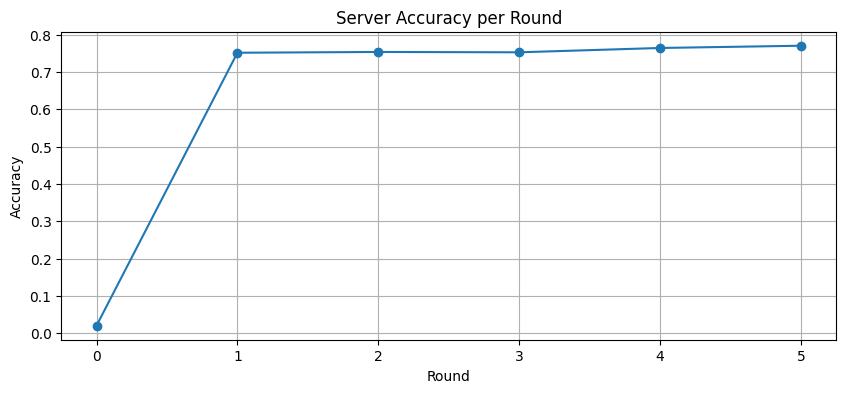

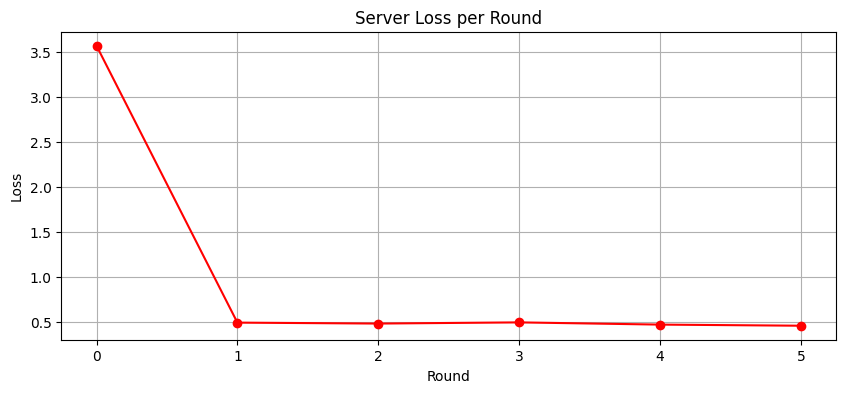

In [ ]:
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# --- LOG START ---
print(f"{Colours.YELLOW.value}\nDeploy simulation... Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier")
print(f"Number of Clients = {NUM_OF_CLIENTS}\n")
print(f"Writing output to: {sub_dir_name}/{test_directory_name}\n{Colours.NORMAL.value}")

# Ghi thông tin ban đầu vào file
with open(f"Output/{sub_dir_name}/{test_directory_name}/Run_details.txt", "a") as f:
    f.write(f"{datetime.datetime.now()} - Deploy simulation... Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier\n")
    f.write(f"{datetime.datetime.now()} - Number of Clients = {NUM_OF_CLIENTS}\n")
    f.write(f"{datetime.datetime.now()} - Original train_df size: {train_df_shape}\n")

    for i in range(len(fl_X_train)):
        f.write(f"{datetime.datetime.now()} - {i}: X Shape {fl_X_train[i].shape}, Y Shape {fl_y_train[i].shape}\n")

    f.write(f"{datetime.datetime.now()} - X_test size: {X_test.shape}\n")
    f.write(f"{datetime.datetime.now()} - y_test size: {y_test.shape}\n")

# --- START SIMULATION ---
start_time = datetime.datetime.now()

ray_init_args = {"num_cpus": 2}

server_accuracy_history = []
server_loss_history = []

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_OF_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_OF_ROUNDS),
    strategy=strategy,
    client_resources={"num_cpus": 1},
    ray_init_args=ray_init_args,
)

end_time = datetime.datetime.now()
print("Total time taken: ", end_time - start_time)

# --- LOG END ---
print(f"{Colours.YELLOW.value}SIMULATION COMPLETE. Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier")
print(f"Number of Clients = {NUM_OF_CLIENTS}{Colours.NORMAL.value}\n")

# Ghi thông tin kết thúc vào file
with open(f"Output/{sub_dir_name}/{test_directory_name}/Run_details.txt", "a") as f:
    f.write(f"{datetime.datetime.now()} - SIMULATION COMPLETE. Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier\n")
    f.write(f"{datetime.datetime.now()} - Total time taken: {end_time - start_time}\n")

# --- PLOT ACCURACY ---
plt.figure(figsize=(10, 4))
plt.plot(server_accuracy_history, marker='o')
plt.title('Server Accuracy per Round')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.grid(True)
plt.savefig(f"Output/{sub_dir_name}/{test_directory_name}/server_accuracy_per_round.png")
plt.show()

# --- PLOT LOSS ---
plt.figure(figsize=(10, 4))
plt.plot(server_loss_history, marker='o', color='red')
plt.title('Server Loss per Round')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig(f"Output/{sub_dir_name}/{test_directory_name}/server_loss_per_round.png")
plt.show()
